In [ ]:
!pip install monai
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from monai.transforms import MapTransform


class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d

In [ ]:
import os
import torch

from torchvision import models
from monai.networks.nets import SegResNet
from monai.inferers import sliding_window_inference

from monai.transforms import EnsureChannelFirstd, NormalizeIntensityd, Orientationd, Spacingd, Activations, AsDiscrete,EnsureTyped


from monai.inferers import SlidingWindowInferer
import os
import glob

from monai.transforms import (Compose, LoadImaged, ToTensord, AddChanneld)
from monai.data import Dataset, DataLoader
from monai.inferers import Inferer
import numpy as np
import nibabel as nib
import sys

import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset

model_path = "/content/drive/MyDrive/Deep learning models/Monai-brats_mri_segmentation/models/model.pt"
 # Use 'cpu' or 'cuda'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

model = SegResNet(
  blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.3
).to(device)



state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
data_dir="/content/drive/MyDrive/Deep learning models/Task082_BraTS2020/Input"

class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data_dict = self.data[index]

        # Save the folder_name before applying transforms
        folder_name = data_dict['folder_name']

        if self.transform:
            data_dict = self.transform(data_dict)

        # Add the folder_name back to the data_dict
        data_dict['folder_name'] = folder_name
        return data_dict






def get_data(data_dir):
    data_list = []

    for f in glob.glob(os.path.join(data_dir, '*')):
        folder_name = os.path.basename(f)
        dict = {}
        dict['image'] = [
            next(glob.iglob(os.path.join(f, '*t1.nii.gz'))),
            next(glob.iglob(os.path.join(f, '*t1ce.nii.gz'))),
            next(glob.iglob(os.path.join(f, '*t2.nii.gz'))),
            next(glob.iglob(os.path.join(f, '*flair.nii.gz')))
        ]
        dict['label'] = next(glob.iglob(os.path.join(f, '*seg.nii.gz')))
        dict['folder_name'] = folder_name
        data_list.append(dict)

    return data_list



transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

##############################
#this part is for one image [0]

# #.unsqueeze(0): Adds a new dimension in the 0th position (the beginning) of the tensor, effectively adding a batch dimension. This is necessary because deep learning models typically expect a batch of input samples. After unsqueezing, the tensor shape changes from (1, 240, 240, 155) to (1, 1, 240, 240, 155).
#data = Dataset(data=get_data('Input')[:1], transform=transform)


#image = data[0]['image'].unsqueeze(0).to(device)  # Add a batch dimension


##########################

inputData=get_data(data_dir)

inputData = inputData[:4]
print(inputData)

data = CustomDataset(inputData, transform=transform)
#print(data.shape)
# image_list = []

# for i in range(len(data)):
#     image = data[i]['image'].unsqueeze(0)
#     image_list.append(image)




inferer = SlidingWindowInferer(
            roi_size=(240, 240, 160),
            sw_batch_size=10,
            overlap=0.5,)

#########################Power analysis###########################

Using device: cuda
[{'image': ['/content/drive/MyDrive/Deep learning models/Task082_BraTS2020/Input/BraTS20_Training_129/BraTS20_Training_129_t1.nii.gz', '/content/drive/MyDrive/Deep learning models/Task082_BraTS2020/Input/BraTS20_Training_129/BraTS20_Training_129_t1ce.nii.gz', '/content/drive/MyDrive/Deep learning models/Task082_BraTS2020/Input/BraTS20_Training_129/BraTS20_Training_129_t2.nii.gz', '/content/drive/MyDrive/Deep learning models/Task082_BraTS2020/Input/BraTS20_Training_129/BraTS20_Training_129_flair.nii.gz'], 'label': '/content/drive/MyDrive/Deep learning models/Task082_BraTS2020/Input/BraTS20_Training_129/BraTS20_Training_129_seg.nii.gz', 'folder_name': 'BraTS20_Training_129'}, {'image': ['/content/drive/MyDrive/Deep learning models/Task082_BraTS2020/Input/BraTS20_Training_090/BraTS20_Training_090_t1.nii.gz', '/content/drive/MyDrive/Deep learning models/Task082_BraTS2020/Input/BraTS20_Training_090/BraTS20_Training_090_t1ce.nii.gz', '/content/drive/MyDrive/Deep learning m

In [ ]:
from monai.data import DataLoader


def enable_dropout(model):
    """ Function to enable the dropout layers during test-time """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

def get_monte_carlo_predictions(data_loader,
                                forward_passes,
                                model,
                                n_classes,
                                n_samples):
    """ Function to get the monte-carlo samples and uncertainty estimates
    through multiple forward passes

    Parameters
    ----------
    data_loader : object
        data loader object from the data loader module
    forward_passes : int
        number of monte-carlo samples/forward passes
    model : object
        keras model
    n_classes : int
        number of classes in the dataset
    n_samples : int
        number of samples in the test set
    """



#print(image.shape)
data_loader = DataLoader(data, batch_size=1, num_workers=0)
forward_passes=10
n_classes=3
n_samples=4

dropout_predictions = np.empty((forward_passes, n_samples, 3, 240, 240, 155))

predictions = np.empty((n_samples, 3, 240, 240, 155))

 #If the model's output size should be torch.Size([1, 3, 240, 240, 155]),
 #this means that the output is a 5-dimensional tensor as represent as the following:

#  1: Batch size (single sample)
#  3: Number of classes
#  240, 240, 155: Spatial dimensions (height, width, depth).
#  in this case, dropout_predictions should be define as above and predictions as below.



# for i in range(forward_passes):
#     model.eval()
#     enable_dropout(model)
#     for j, image in enumerate(data_loader):
#         image = image['image'].to(device)
#         #print(image.shape)
#         with torch.no_grad():
#             output = inferer(image, model)
#         dropout_predictions[i, j, :, :, :, :] = output.cpu().numpy()

import gc

labels = []

# Assuming you have 3 cases, you can loop through the data and get the labels
# Assuming you have 3 cases, you can loop through the data and get the labels
for i in range(n_samples):
    label = data[i]['label'].to(device)
    labels.append(label)

# Convert the labels list to a tensor
labels = torch.stack(labels)

# Print the size of the label tensor
print("Label tensor size:", labels.size())


with torch.no_grad():
    for i in range(forward_passes):
        model.eval()
        enable_dropout(model)
        for j, data_dict in enumerate(data_loader):
            image = data_dict['image'].to(device)
            with torch.no_grad():
                output = inferer(image, model)
            dropout_predictions[i, j, :, :, :, :] = output.cpu().numpy()

            # Free up memory
            del output
            del image
            torch.cuda.empty_cache()
            gc.collect()

# Now you can access the folder_name for each sample
for i, data_dict in enumerate(data):
    print(f"Case {i + 1}: {data_dict['folder_name']}")




Label tensor size: torch.Size([4, 3, 240, 240, 155])
Case 1: BraTS20_Training_129
Case 2: BraTS20_Training_090
Case 3: BraTS20_Training_096
Case 4: BraTS20_Training_091


In [ ]:
pred=dropout_predictions

# print("Type of labels:", type(labels))
# print("Type of pred:", type(pred))
pred = torch.from_numpy(pred).float()
pred = pred.to(device)

print(labels.shape)
print(pred.shape)

torch.Size([4, 3, 240, 240, 155])
torch.Size([10, 4, 3, 240, 240, 155])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F



# for i, data_dict in enumerate(data):
#     print(f"Case {i + 1}: {data_dict['folder_name']}")




class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, pred, label, smooth=1):
        # Comment out if your model contains a sigmoid or equivalent activation layer
        pred = F.sigmoid(pred)

        # Initialize lists to store the individual losses and coefficients
        losses = []
        dice_coeffs = []

        # Loop through each channel in the predictions
        for channel in range(pred.shape[1]):
            # Extract the single channel prediction and label
            pred_channel = pred[:, channel].reshape(-1)
            label_channel = labels[:, channel].reshape(-1)

            intersection = (pred_channel * label_channel).sum()
            dice = (2.*intersection + smooth)/(pred_channel.sum() + label_channel.sum() + smooth)

            # Append the loss and coefficient to their respective lists
            losses.append(1 - dice)
            dice_coeffs.append(dice)

        # Stack the losses and coefficients into tensors
        losses = torch.stack(losses)
        dice_coeffs = torch.stack(dice_coeffs)

        return losses, dice_coeffs

# Instantiate the DiceLoss class
dice_loss = DiceLoss()


# Calculate the Dice coefficient for each prediction
for case_index, data_dict in enumerate(data):
    case_folder_name = data_dict['folder_name']
    case_label = data_dict['label'].to(device)

    for i in range(pred.shape[0]):
        single_pred = pred[i]  # Extract a single prediction
        losses, dice_coeffs = dice_loss(single_pred, case_label)
        for channel, (loss, dice_coeff) in enumerate(zip(losses, dice_coeffs)):
            print(f"Case {case_folder_name}, Prediction {i + 1}, Channel {channel + 1}: Dice Loss = {loss.item()}, Dice Coefficient = {dice_coeff.item()}")



In [ ]:
import pandas as pd

# Create an empty list to store the results
results = []

# Iterate through the cases
for case_index, data_dict in enumerate(data):
    case_folder_name = data_dict['folder_name']
    case_labels = data_dict['label'].to(device)

    # Iterate through the predictions and channels
    for i in range(pred.shape[0]):
        single_pred = pred[i]  # Extract a single prediction
        losses, dice_coeffs = dice_loss(single_pred, case_labels)
        for channel, (loss, dice_coeff) in enumerate(zip(losses, dice_coeffs)):
            # Append the result as a dictionary to the list
            results.append({
                'Case': case_folder_name,
                'Prediction': i + 1,
                'Channel': channel + 1,
                'Dice Loss': loss.item(),
                'Dice Coefficient': dice_coeff.item()
            })

# Create a DataFrame from the results list
df_dice = pd.DataFrame(results)

# Display the DataFrame
print(df_dice)

# Save the DataFrame to a CSV file
#df_dice.to_csv("dice_results.csv", index=False)


                     Case  Prediction  Channel  Dice Loss  Dice Coefficient
0    BraTS20_Training_129           1        1   0.849284          0.150716
1    BraTS20_Training_129           1        2   0.365160          0.634840
2    BraTS20_Training_129           1        3   0.941691          0.058309
3    BraTS20_Training_129           2        1   0.852769          0.147231
4    BraTS20_Training_129           2        2   0.346872          0.653128
..                    ...         ...      ...        ...               ...
175  BraTS20_Training_096          19        2   0.358369          0.641631
176  BraTS20_Training_096          19        3   0.935269          0.064731
177  BraTS20_Training_096          20        1   0.842279          0.157721
178  BraTS20_Training_096          20        2   0.354881          0.645119
179  BraTS20_Training_096          20        3   0.937935          0.062065

[180 rows x 5 columns]


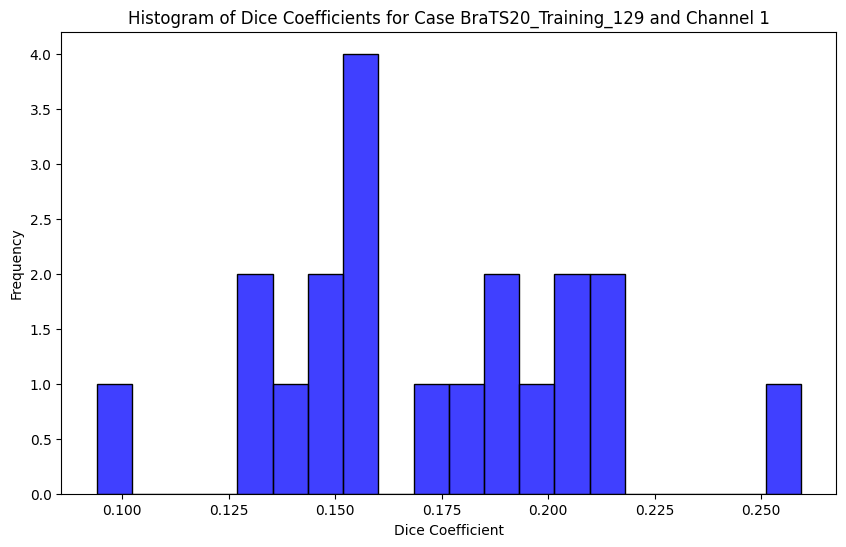

Case BraTS20_Training_129, Channel 1
Statistics=0.969, p=0.738
Sample looks Gaussian (fail to reject H0)




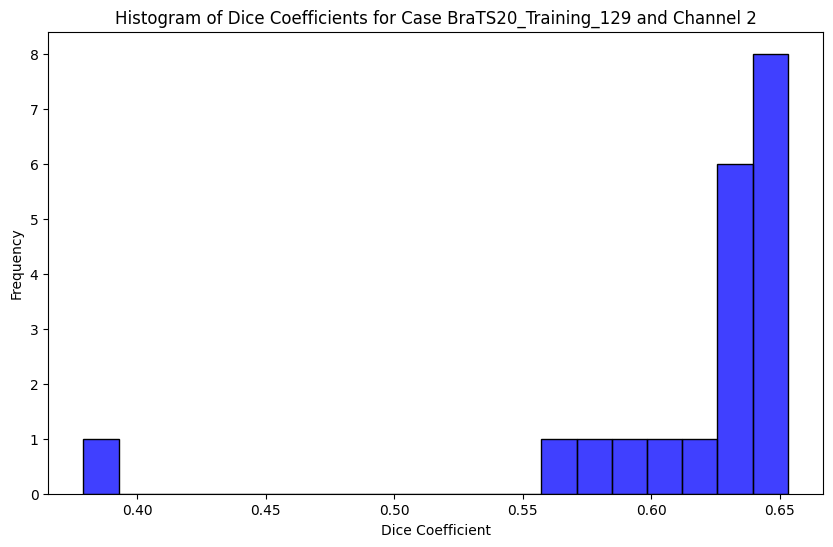

Case BraTS20_Training_129, Channel 2
Statistics=0.563, p=0.000
Sample does not look Gaussian (reject H0)




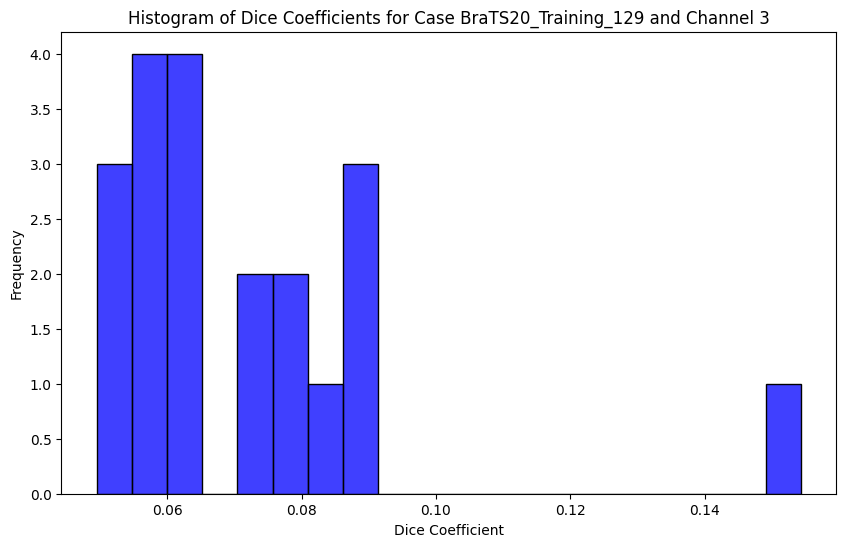

Case BraTS20_Training_129, Channel 3
Statistics=0.755, p=0.000
Sample does not look Gaussian (reject H0)




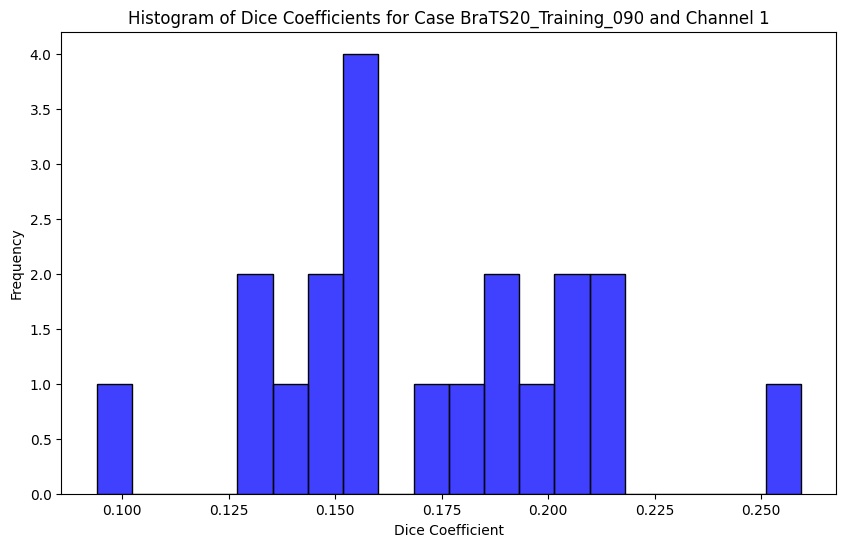

Case BraTS20_Training_090, Channel 1
Statistics=0.969, p=0.738
Sample looks Gaussian (fail to reject H0)




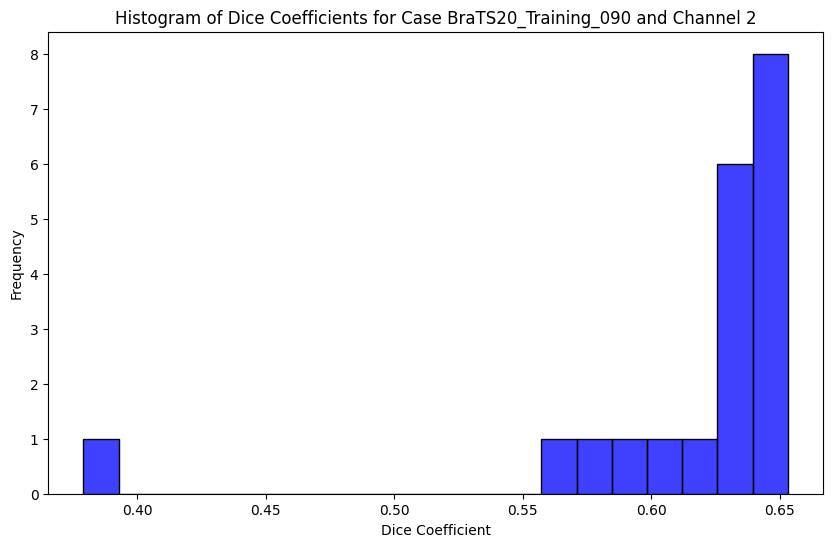

Case BraTS20_Training_090, Channel 2
Statistics=0.563, p=0.000
Sample does not look Gaussian (reject H0)




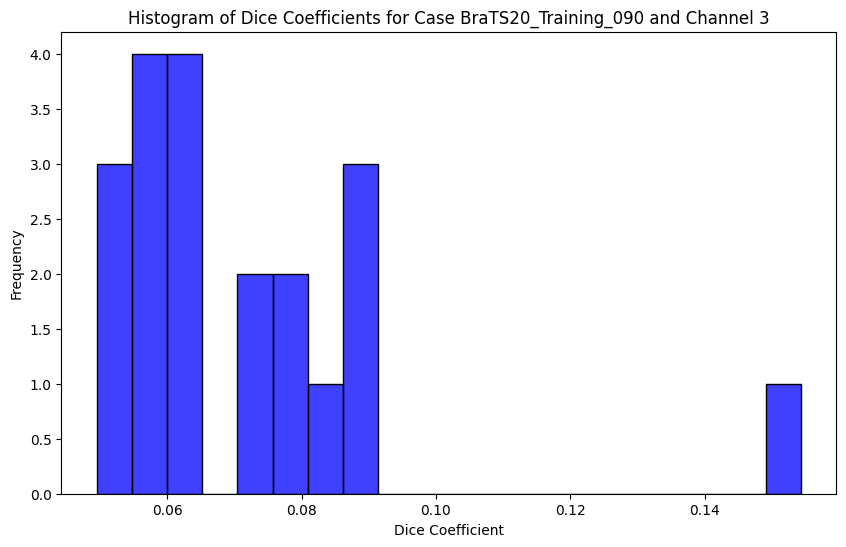

Case BraTS20_Training_090, Channel 3
Statistics=0.755, p=0.000
Sample does not look Gaussian (reject H0)




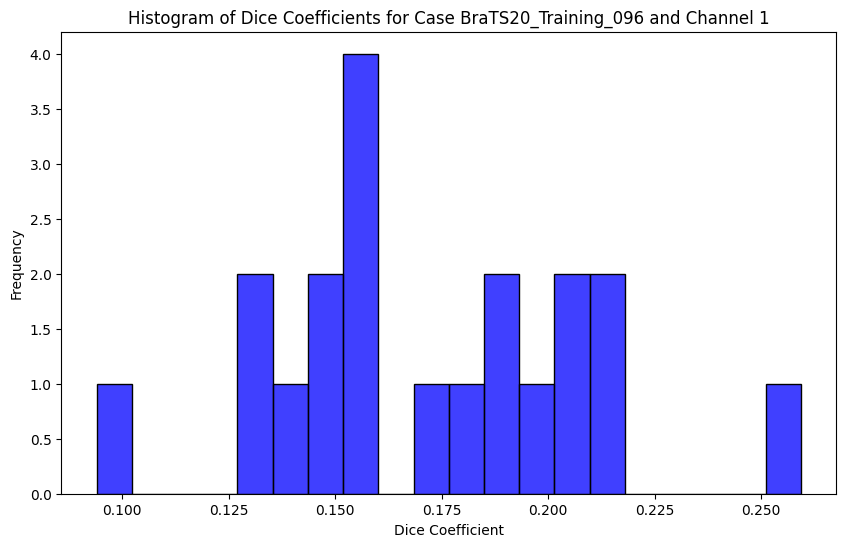

Case BraTS20_Training_096, Channel 1
Statistics=0.969, p=0.738
Sample looks Gaussian (fail to reject H0)




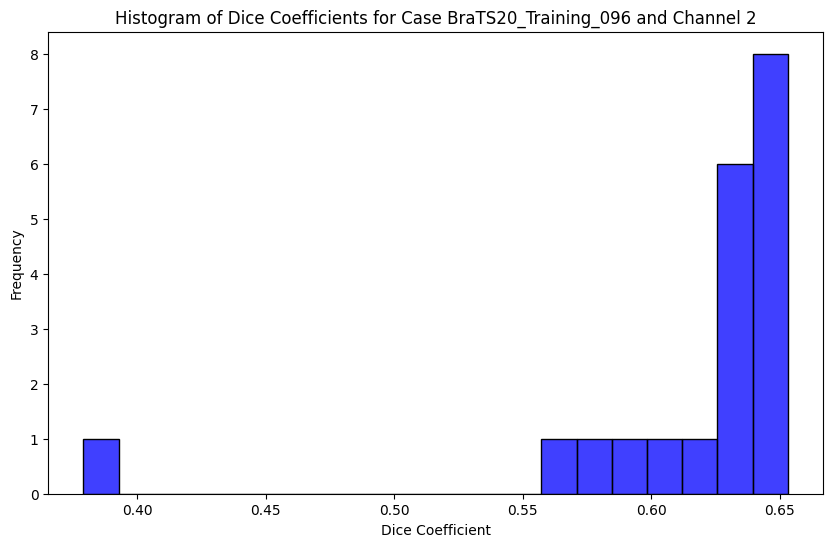

Case BraTS20_Training_096, Channel 2
Statistics=0.563, p=0.000
Sample does not look Gaussian (reject H0)




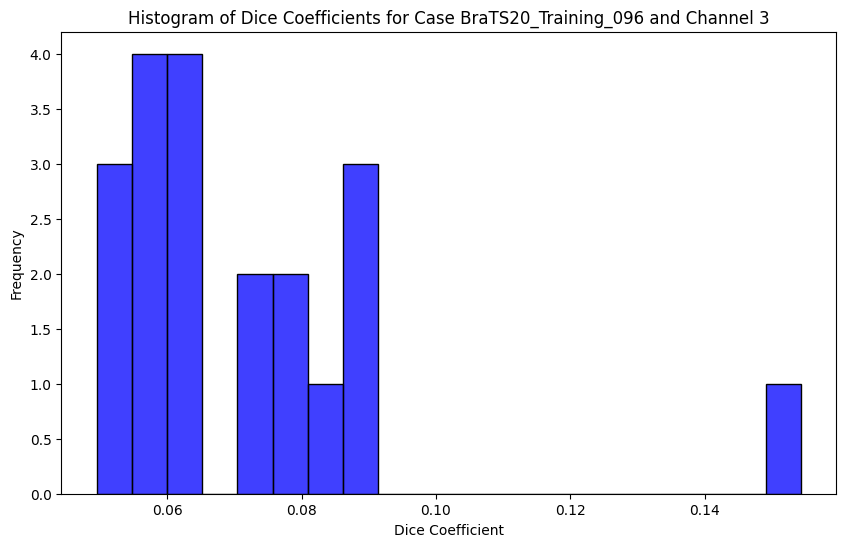

Case BraTS20_Training_096, Channel 3
Statistics=0.755, p=0.000
Sample does not look Gaussian (reject H0)




In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

# List of unique cases and channels
cases = df_dice['Case'].unique()
channels = df_dice['Channel'].unique()

for case in cases:
    for channel in channels:
        # Subset dataframe for the specific case and channel
        df_case_channel = df_dice[(df_dice['Case'] == case) & (df_dice['Channel'] == channel)]

        # Check if there are enough data points to plot a histogram and perform Shapiro-Wilk test
        if len(df_case_channel) >= 3:
            # Plot histogram for the case and channel
            plt.figure(figsize=(10, 6))
            sns.histplot(df_case_channel['Dice Coefficient'], bins=20, kde=False, color='blue')
            plt.title('Histogram of Dice Coefficients for Case {} and Channel {}'.format(case, channel))
            plt.xlabel('Dice Coefficient')
            plt.ylabel('Frequency')
            plt.show()

            # Perform Shapiro-Wilk test for the case and channel
            stat, p = shapiro(df_case_channel['Dice Coefficient'])
            print('Case {}, Channel {}'.format(case, channel))
            print('Statistics=%.3f, p=%.3f' % (stat, p))

            # Interpret
            alpha = 0.05
            if p > alpha:
                print('Sample looks Gaussian (fail to reject H0)')
            else:
                print('Sample does not look Gaussian (reject H0)')
            print("\n")
        else:
            print('Not enough data points for Case {}, Channel {} to plot histogram or perform Shapiro-Wilk test\n'.format(case, channel))


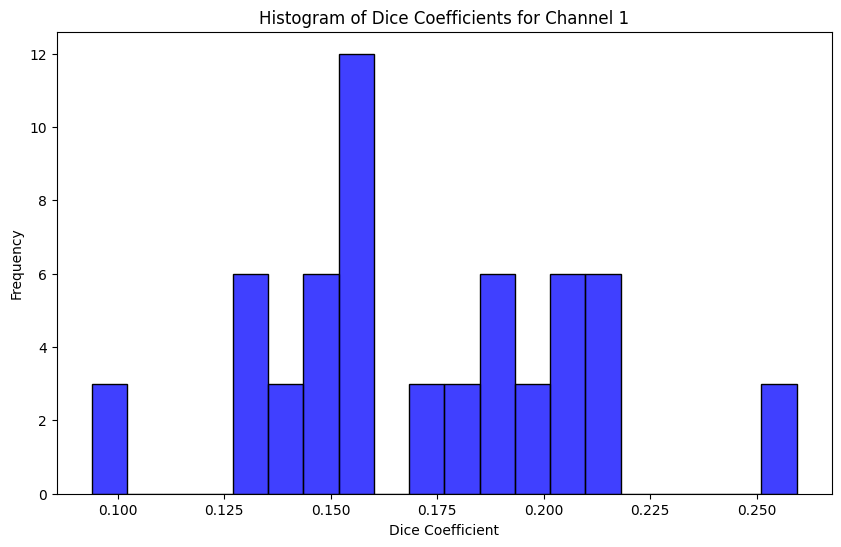

Channel 1
Statistics=0.953, p=0.022
Sample does not look Gaussian (reject H0)




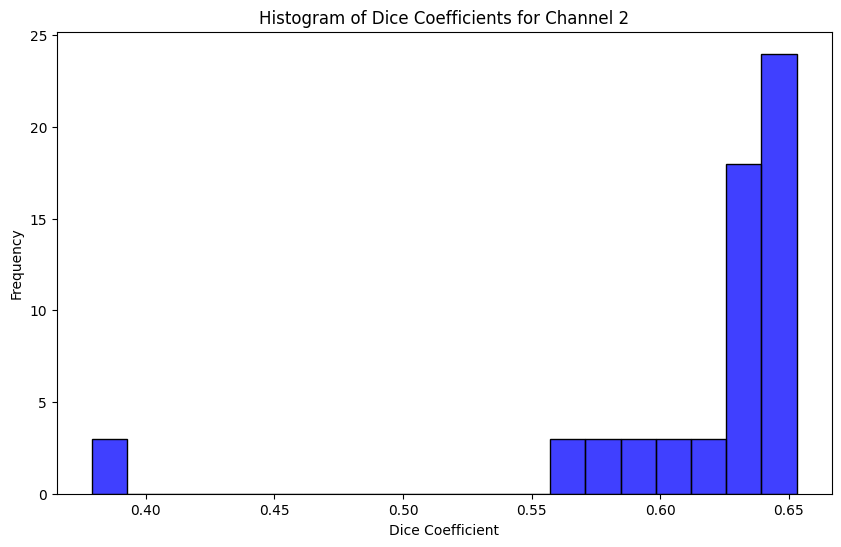

Channel 2
Statistics=0.550, p=0.000
Sample does not look Gaussian (reject H0)




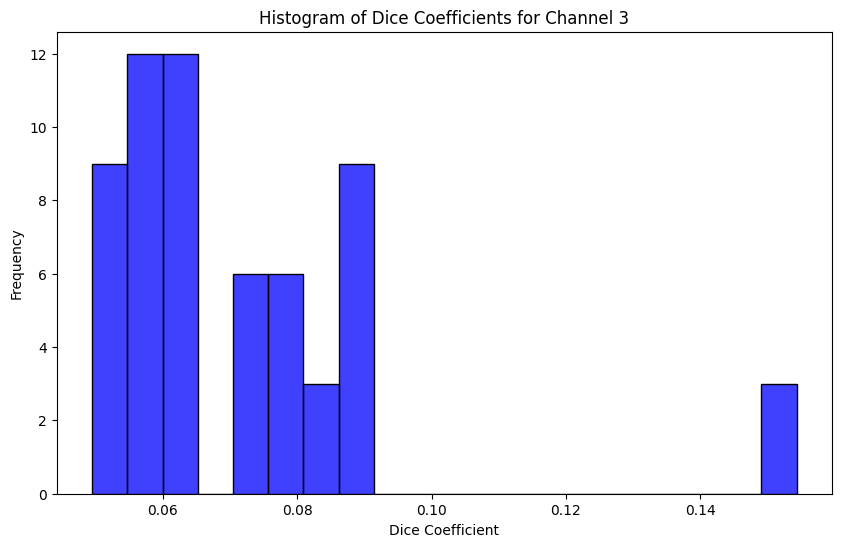

Channel 3
Statistics=0.740, p=0.000
Sample does not look Gaussian (reject H0)




In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

# List of unique channels
channels = df_dice['Channel'].unique()

for channel in channels:
    # Subset dataframe for the specific channel
    df_channel = df_dice[df_dice['Channel'] == channel]

    # Plot histogram for the channel
    plt.figure(figsize=(10, 6))
    sns.histplot(df_channel['Dice Coefficient'], bins=20, kde=False, color='blue')
    plt.title('Histogram of Dice Coefficients for Channel {}'.format(channel))
    plt.xlabel('Dice Coefficient')
    plt.ylabel('Frequency')
    plt.show()

    # Perform Shapiro-Wilk test for the channel
    stat, p = shapiro(df_channel['Dice Coefficient'])
    print('Channel {}'.format(channel))
    print('Statistics=%.3f, p=%.3f' % (stat, p))

    # Interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')
    print("\n")


Channel 1 Confidence Interval: 0.031696625206104605, 0.04323824416233713


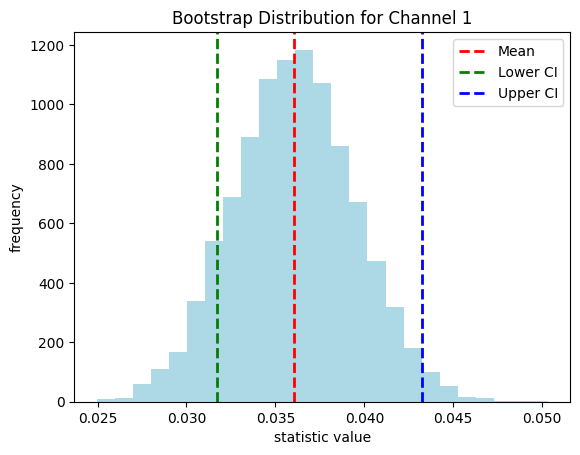

Channel 2 Confidence Interval: 0.04004781962400436, 0.08393797866278636


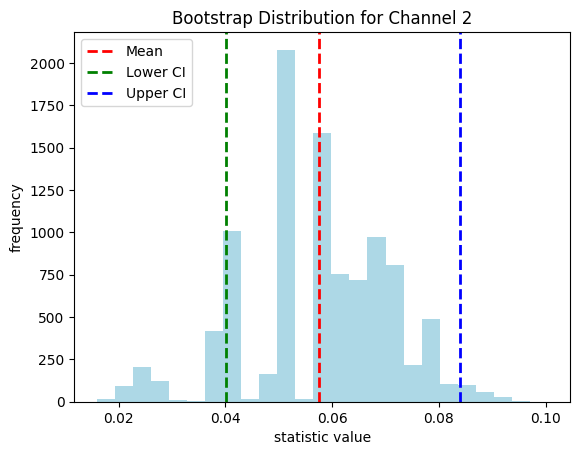

Channel 3 Confidence Interval: 0.016608776121496412, 0.03069031843226699


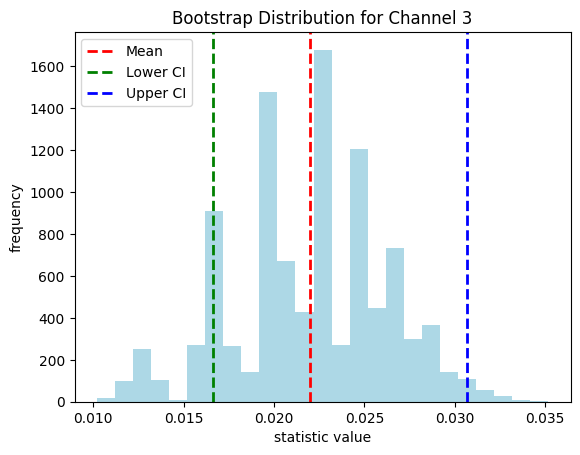

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import bootstrap

# List of unique channels
channels = df_dice['Channel'].unique()

for channel in channels:
    # Subset dataframe for the specific channel
    df_channel = df_dice[df_dice['Channel'] == channel]['Dice Coefficient']

    # Convert DataFrame to numpy array
    data = df_channel.to_numpy()

    data = (data,)  # samples must be in a sequence
    res = bootstrap(data, np.std, confidence_level=0.95, method='BCa',n_resamples=9999)

    # Print the lower and upper confidence intervals
    print(f"Channel {channel} Confidence Interval: {res.confidence_interval.low}, {res.confidence_interval.high}")

    fig, ax = plt.subplots()
    ax.hist(res.bootstrap_distribution, bins=25, color='lightblue')
    ax.set_title('Bootstrap Distribution for Channel {}'.format(channel))
    ax.set_xlabel('statistic value')
    ax.set_ylabel('frequency')

    # Draw vertical lines for mean and confidence intervals
    ax.axvline(res.bootstrap_distribution.mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
    ax.axvline(res.confidence_interval.low, color='green', linestyle='dashed', linewidth=2, label='Lower CI')
    ax.axvline(res.confidence_interval.high, color='blue', linestyle='dashed', linewidth=2, label='Upper CI')

    # Add legend to the plot
    ax.legend()
    plt.show()


In [ ]:
df_dice['Channel'].value_counts()

1    60
2    60
3    60
Name: Channel, dtype: int64

In [ ]:
import torch
import numpy as np
from scipy.spatial.distance import directed_hausdorff
import pandas as pd

# # Initialize a list to hold the Hausdorff distances, case names, prediction numbers, and channel numbers
# hausdorff_data = []


# # Calculate Hausdorff distance for each prediction
# for i in range(pred.shape[0]):  # loop over forward passes
#     for j in range(pred.shape[1]):  # loop over cases
#         for k in range(pred.shape[2]):  # loop over channels
#             # Extract each channel separately for each case in each forward pass
#             pred_channel = pred[i, j, k].reshape(-1, 1)  # reshape to (N, 1)
#             label_channel = labels[j, k].reshape(-1, 1)  # reshape to (N, 1)

#             # Compute the Hausdorff distance for each channel
#             d, _, _ = directed_hausdorff(pred_channel.cpu().numpy(), label_channel.cpu().numpy())
#             hausdorff_data.append({
#                 'Case': j+1,
#                 'Prediction': i+1,
#                 'Channel_Number': k+1,
#                 'Hausdorff_Distance': d
#             })

# # Convert the list into a pandas DataFrame
# df = pd.DataFrame(hausdorff_data)

# # Save the DataFrame to a CSV file
# df.to_csv("Hausdorff_Distance.csv", index=False)


import pandas as pd

# Initialize a list to hold the Hausdorff distances
hausdorff_data = []

# Iterate through the cases
for case_index, data_dict in enumerate(data):
    case_folder_name = data_dict['folder_name']
    labels = data_dict['label'].to(device)

    # Iterate through the predictions and channels
    for i in range(pred.shape[0]):  # loop over forward_passes
        for j in range(pred.shape[1]):  # loop over samples
            for k in range(pred.shape[2]):  # loop over channels
                # Extract each channel separately for each sample in each prediction
                pred_channel = pred[i, j, k].reshape(-1, 1)  # reshape to (N, 1)
                label_channel = labels[j, k].reshape(-1, 1)  # reshape to (N, 1)

                # Compute the Hausdorff distance for each channel
                d, _, _ = directed_hausdorff(pred_channel.cpu().numpy(), label_channel.cpu().numpy())
                hausdorff_data.append({
                    'Case': case_folder_name,
                    'Prediction_Number': i + 1,
                    'Channel_Number': k + 1,
                    'Hausdorff_Distance': d
                })

# Convert the list into a pandas DataFrame
df = pd.DataFrame(hausdorff_data)

# Display the DataFrame
print(df)

# Save the DataFrame to a CSV file
df.to_csv("Hausdorff_Distance.csv", index=False)


                     Case  Prediction_Number  Channel_Number  \
0    BraTS20_Training_129                  1               1   
1    BraTS20_Training_129                  1               2   
2    BraTS20_Training_129                  1               3   
3    BraTS20_Training_129                  1               1   
4    BraTS20_Training_129                  1               2   
..                    ...                ...             ...   
175  BraTS20_Training_090                 15               2   
176  BraTS20_Training_090                 15               3   
177  BraTS20_Training_090                 15               1   
178  BraTS20_Training_090                 15               2   
179  BraTS20_Training_090                 15               3   

     Hausdorff_Distance  
0             14.585680  
1             17.842796  
2             18.159952  
3             12.958130  
4             15.189863  
..                  ...  
175           17.433872  
176           23.918322

In [ ]:
df.to_csv("Hausdorff_Distance.csv", index=False)

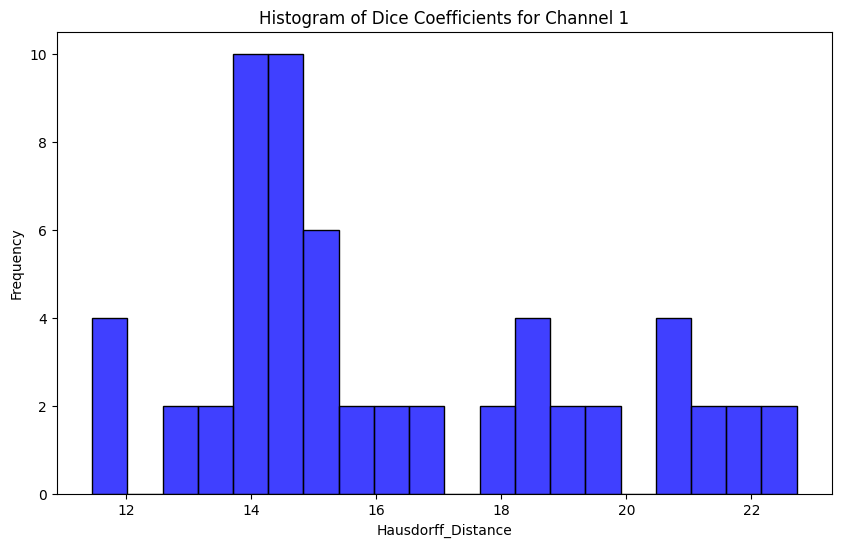

Channel 1
Statistics=0.915, p=0.001
Sample does not look Gaussian (reject H0)




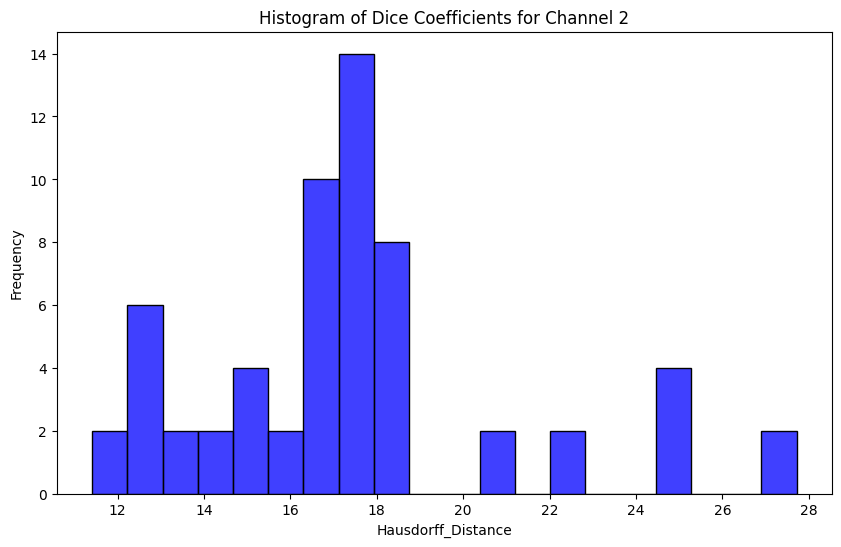

Channel 2
Statistics=0.903, p=0.000
Sample does not look Gaussian (reject H0)




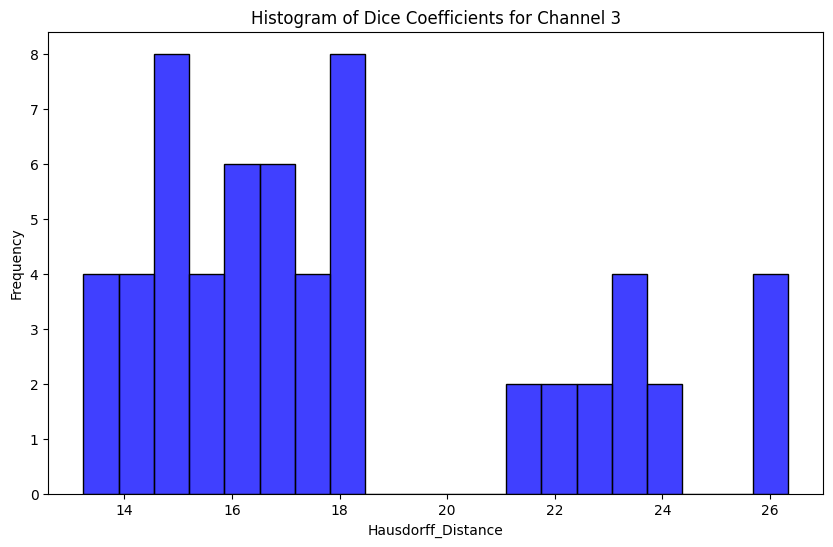

Channel 3
Statistics=0.875, p=0.000
Sample does not look Gaussian (reject H0)




In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

# List of unique channels
channels = df['Channel_Number'].unique()

for channel in channels:
    # Subset dataframe for the specific channel
    df_channel = df[df['Channel_Number'] == channel]

    # Plot histogram for the channel
    plt.figure(figsize=(10, 6))
    sns.histplot(df_channel['Hausdorff_Distance'], bins=20, kde=False, color='blue')
    plt.title('Histogram of Dice Coefficients for Channel {}'.format(channel))
    plt.xlabel('Hausdorff_Distance')
    plt.ylabel('Frequency')
    plt.show()

    # Perform Shapiro-Wilk test for the channel
    stat, p = shapiro(df_channel['Hausdorff_Distance'])
    print('Channel {}'.format(channel))
    print('Statistics=%.3f, p=%.3f' % (stat, p))

    # Interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')
    print("\n")


Channel 1 Confidence Interval: 2.62579770314092, 3.4765527369482463


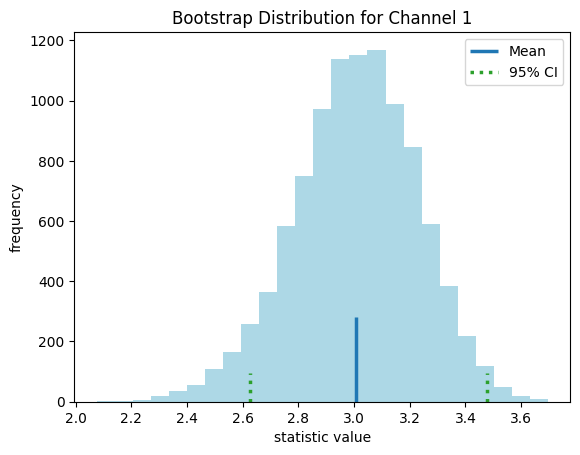

Channel 2 Confidence Interval: 2.948447859893992, 4.569189167264637


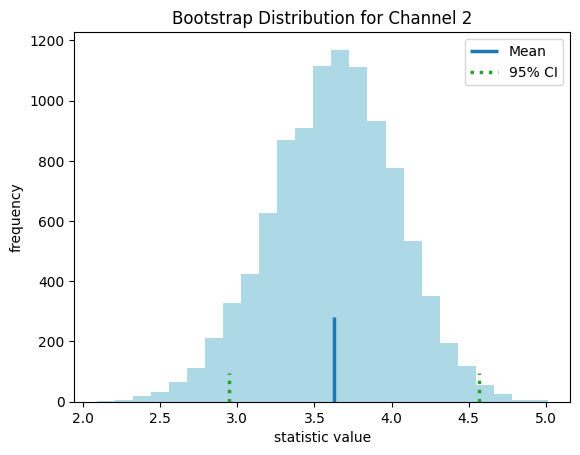

Channel 3 Confidence Interval: 3.1572897242324256, 4.336179264395486


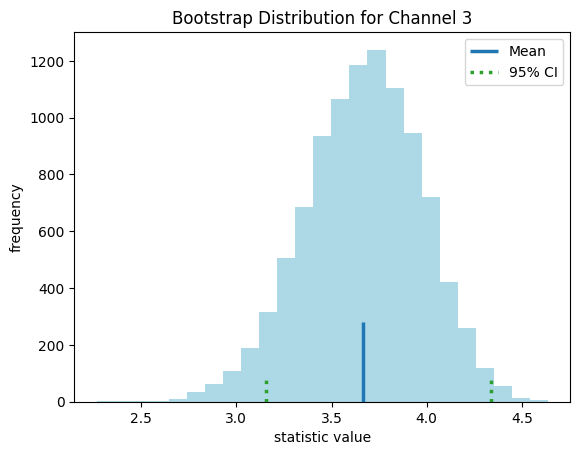

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import bootstrap

# List of unique channels
channels = df['Channel_Number'].unique()

for channel in channels:
    # Subset dataframe for the specific channel
    df_channel = df[df['Channel_Number'] == channel]['Hausdorff_Distance']

    # Convert DataFrame to numpy array
    data = df_channel.to_numpy()

    data = (data,)  # samples must be in a sequence
    res = bootstrap(data, np.std, confidence_level=0.95, method='BCa',n_resamples=9999)

    # Print the lower and upper confidence intervals
    print(f"Channel {channel} Confidence Interval: {res.confidence_interval.low}, {res.confidence_interval.high}")

    fig, ax = plt.subplots()
    ax.hist(res.bootstrap_distribution, bins=25, color='lightblue')
    ax.set_title('Bootstrap Distribution for Channel {}'.format(channel))
    ax.set_xlabel('statistic value')
    ax.set_ylabel('frequency')

    # Draw vertical lines for mean and confidence intervals
    # ax.axvline(res.bootstrap_distribution.mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
    # ax.axvline(res.confidence_interval.low, color='green', linestyle='dashed', linewidth=2, label='Lower CI')
    # ax.axvline(res.confidence_interval.high, color='blue', linestyle='dashed', linewidth=2, label='Upper CI')
    ax.vlines(res.bootstrap_distribution.mean(), [0], 280, lw=2.5, linestyle="-", label="Mean")
    ax.vlines(res.confidence_interval.low, [0], 95, lw=2.5, linestyle="dotted", label="95% CI", color="C2")
    ax.vlines(res.confidence_interval.high, [0], 95, lw=2.5, linestyle="dotted", color="C2")
    # Add legend to the plot
    ax.legend()
    plt.show()


In [ ]:
# import pandas as pd

# # Assuming `labels` and `pred` are PyTorch tensors
# # Average predictions along the forward passes dimension
# pred_avg = torch.mean(pred, dim=0)

# # Convert predictions to binary values (1: positive, 0: negative)
# binary_pred = (pred_avg > 0.5).float()

# # Calculate true positives, false positives, and false negatives for each sample
# true_positives = torch.sum(binary_pred * labels, dim=(1, 2, 3, 4))
# false_positives = torch.sum(binary_pred * (1 - labels), dim=(1, 2, 3, 4))
# false_negatives = torch.sum((1 - binary_pred) * labels, dim=(1, 2, 3, 4))
# true_negatives = torch.sum((1 - binary_pred) * (1 - labels), dim=(1, 2, 3, 4))

# folder_names = [data_dict['folder_name'] for data_dict in data]

# fpr = false_positives / (false_positives + true_positives)
# fnr = false_negatives / (false_negatives + true_positives)

# # Print the results for each folder
# # for i, folder_name in enumerate(folder_names):
# #     print(f"{folder_name}:")
# #     print(f"True Positives: {true_positives[i].item()}")
# #     print(f"False Positives: {false_positives[i].item()}")
# #     print(f"False Negatives: {false_negatives[i].item()}")
# #     print(f"False Positive Rate: {fpr[i].item()}")
# #     print(f"False Negative Rate: {fnr[i].item()}")

# results = pd.DataFrame({'folder_name': folder_names,
#                         'true_positives': true_positives.cpu().numpy(),
#                         'true_negatives': true_negatives.cpu().numpy(),
#                         'false_positives': false_positives.cpu().numpy(),
#                         'false_negatives': false_negatives.cpu().numpy(),
#                         'false_positive_rate': fpr.cpu().numpy(),
#                         'false_negative_rate': fnr.cpu().numpy()})

# # Print the results DataFrame
# print(results)
# results.to_csv("table fpr.csv", index=False)


import pandas as pd

# Assuming `labels` and `pred` are PyTorch tensors
# Average predictions along the forward passes dimension
pred_avg = torch.mean(pred, dim=0)

# Convert predictions to binary values (1: positive, 0: negative)
binary_pred = (pred_avg > 0.5).float()

# Calculate true positives, false positives, false negatives, and true negatives for each sample and each channel
true_positives = torch.sum(binary_pred * labels, dim=(2, 3, 4)).cpu().numpy()
false_positives = torch.sum(binary_pred * (1 - labels), dim=(2, 3, 4)).cpu().numpy()
false_negatives = torch.sum((1 - binary_pred) * labels, dim=(2, 3, 4)).cpu().numpy()
true_negatives = torch.sum((1 - binary_pred) * (1 - labels), dim=(2, 3, 4)).cpu().numpy()

folder_names = [data_dict['folder_name'] for data_dict in data]

# Calculate FPR and FNR for each channel of each case
fpr = false_positives / (false_positives + true_positives)
fnr = false_negatives / (false_negatives + true_positives)

# Create a DataFrame for each channel and concatenate them
results_list = []
for channel in range(3):
    results = pd.DataFrame({'folder_name': folder_names,
                            'channel': channel+1,
                            'true_positives': true_positives[:, channel],
                            'true_negatives': true_negatives[:, channel],
                            'false_positives': false_positives[:, channel],
                            'false_negatives': false_negatives[:, channel],
                            'false_positive_rate': fpr[:, channel],
                            'false_negative_rate': fnr[:, channel]})
    results_list.append(results)

# Concatenate results DataFrames for all channels
all_channels_results = pd.concat(results_list, ignore_index=True)

# Print the results DataFrame
print(all_channels_results)
all_channels_results.to_csv("table fpr_fnr.csv", index=False)










             folder_name  channel  true_positives  true_negatives  \
0   BraTS20_Training_129        1          2597.0       8872958.0   
1   BraTS20_Training_090        1           837.0       8900014.0   
2   BraTS20_Training_096        1          1684.0       8891874.0   
3   BraTS20_Training_091        1         39742.0       8779320.0   
4   BraTS20_Training_129        2         49448.0       8857595.0   
5   BraTS20_Training_090        2         19960.0       8891269.0   
6   BraTS20_Training_096        2         43400.0       8856971.0   
7   BraTS20_Training_091        2        104086.0       8770864.0   
8   BraTS20_Training_129        3          1101.0       8875035.0   
9   BraTS20_Training_090        3            44.0       8916109.0   
10  BraTS20_Training_096        3          1524.0       8892216.0   
11  BraTS20_Training_091        3             0.0       8807944.0   

    false_positives  false_negatives  false_positive_rate  false_negative_rate  
0            4245.0  

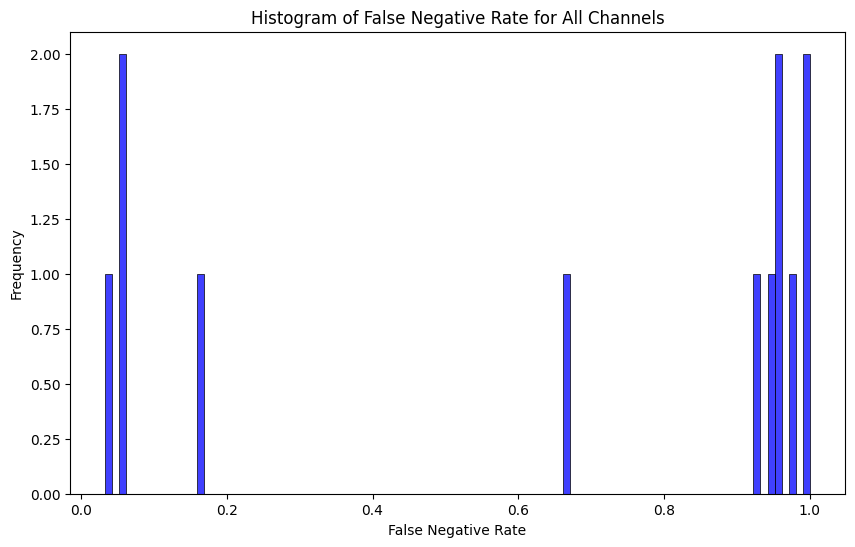

Statistics=0.725, p=0.001
Sample does not look Gaussian (reject H0)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

# Gather all false_negative_rate values from all channels
all_fnr = all_channels_results['false_negative_rate'].values

# Plot histogram for all false_negative_rate values
plt.figure(figsize=(10, 6))
sns.histplot(all_fnr, bins=100, kde=False, color='blue')
plt.title('Histogram of False Negative Rate for All Channels')
plt.xlabel('False Negative Rate')
plt.ylabel('Frequency')
plt.show()

# Perform Shapiro-Wilk test
stat, p = shapiro(all_fnr)
print('Statistics=%.3f, p=%.3f' % (stat, p))

# Interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')


In [ ]:
print("Total number of values used for the histogram: ", len(all_fnr))


Total number of values used for the histogram:  12


Confidence Interval for False Negative Rate: 0.3769887572926371, 0.8542720289746684


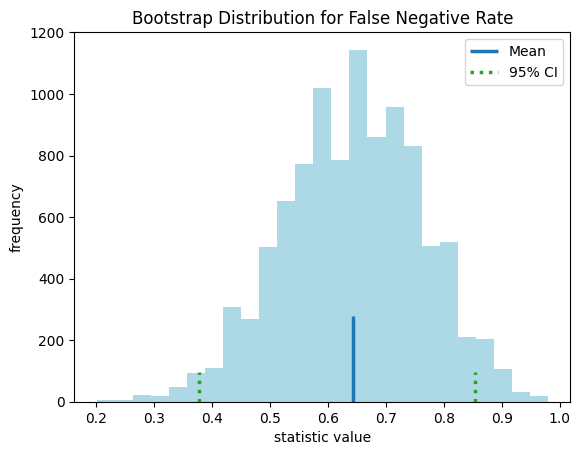

In [ ]:
from scipy.stats import bootstrap



# Prepare data for bootstrap
data = (all_fnr,)  # samples must be in a sequence

# Perform bootstrap
res = bootstrap(data, np.mean, confidence_level=0.95, method='BCa', n_resamples=9999)

# Print the lower and upper confidence intervals
print(f"Confidence Interval for False Negative Rate: {res.confidence_interval.low}, {res.confidence_interval.high}")

# Plot bootstrap distribution
fig, ax = plt.subplots()
ax.hist(res.bootstrap_distribution, bins=25, color='lightblue')
ax.set_title('Bootstrap Distribution for False Negative Rate')
ax.set_xlabel('statistic value')
ax.set_ylabel('frequency')

# Draw vertical lines for mean and confidence intervals
ax.vlines(res.bootstrap_distribution.mean(), [0], 280, lw=2.5, linestyle="-", label="Mean")
ax.vlines(res.confidence_interval.low, [0], 95, lw=2.5, linestyle="dotted", label="95% CI", color="C2")
ax.vlines(res.confidence_interval.high, [0], 95, lw=2.5, linestyle="dotted", color="C2")
# ax.axvline(res.bootstrap_distribution.mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
  # ax.axvline(res.confidence_interval.low, color='green', linestyle='dashed', linewidth=2, label='Lower CI')
    # ax.axvline(res.confidence_interval.high, color='blue', linestyle='dashed', linewidth=2, label='Upper CI')

# Add legend to the plot
ax.legend()
plt.show()


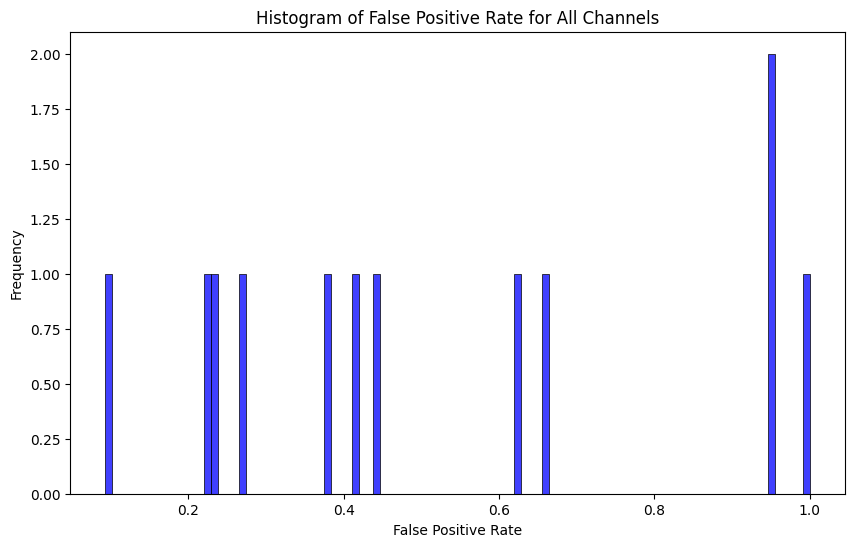

Statistics=0.725, p=0.001
Sample does not look Gaussian (reject H0)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

# Gather all false_negative_rate values from all channels
all_fpr = all_channels_results['false_positive_rate'].values

# Plot histogram for all false_negative_rate values
plt.figure(figsize=(10, 6))
sns.histplot(all_fpr, bins=100, kde=False, color='blue')
plt.title('Histogram of False Positive Rate for All Channels')
plt.xlabel('False Positive Rate')
plt.ylabel('Frequency')
plt.show()

# Perform Shapiro-Wilk test
stat, p = shapiro(all_fnr)
print('Statistics=%.3f, p=%.3f' % (stat, p))

# Interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')


Confidence Interval for False Positive Rate: 0.3666052990232235, 0.7117408047303311


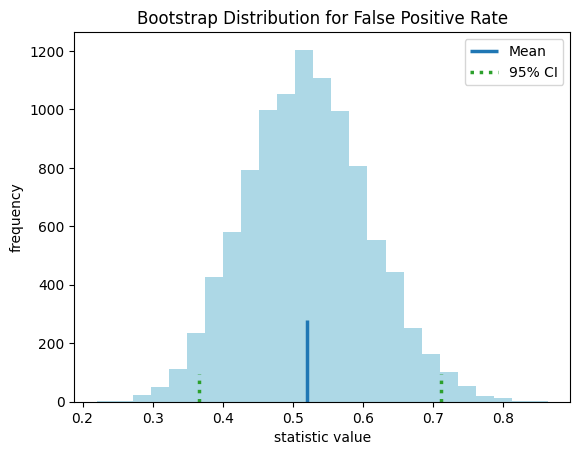

In [ ]:
from scipy.stats import bootstrap



# Prepare data for bootstrap
data = (all_fpr,)  # samples must be in a sequence

# Perform bootstrap
res = bootstrap(data, np.mean, confidence_level=0.95, method='BCa', n_resamples=9999)

# Print the lower and upper confidence intervals
print(f"Confidence Interval for False Positive Rate: {res.confidence_interval.low}, {res.confidence_interval.high}")

# Plot bootstrap distribution
fig, ax = plt.subplots()
ax.hist(res.bootstrap_distribution, bins=25, color='lightblue')
ax.set_title('Bootstrap Distribution for False Positive Rate')
ax.set_xlabel('statistic value')
ax.set_ylabel('frequency')

# Draw vertical lines for mean and confidence intervals
ax.vlines(res.bootstrap_distribution.mean(), [0], 280, lw=2.5, linestyle="-", label="Mean")
ax.vlines(res.confidence_interval.low, [0], 95, lw=2.5, linestyle="dotted", label="95% CI", color="C2")
ax.vlines(res.confidence_interval.high, [0], 95, lw=2.5, linestyle="dotted", color="C2")
# ax.axvline(res.bootstrap_distribution.mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
  # ax.axvline(res.confidence_interval.low, color='green', linestyle='dashed', linewidth=2, label='Lower CI')
    # ax.axvline(res.confidence_interval.high, color='blue', linestyle='dashed', linewidth=2, label='Upper CI')

# Add legend to the plot
ax.legend()
plt.show()


In [ ]:

# class IoULoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(IoULoss, self).__init__()

#     def forward(self, pred, label, smooth=1):

#         #comment out if your model contains a sigmoid or equivalent activation layer
#         pred = F.sigmoid(pred)

#         #flatten label and prediction tensors
#         pred = pred.view(-1)
#         label = labels.view(-1)

#         #intersection is equivalent to True Positive count
#         #union is the mutually inclusive area of all labels & predictions
#         intersection = (pred * label).sum()
#         total = (pred + label).sum()
#         union = total - intersection

#         IoU = (intersection + smooth)/(union + smooth)

#         return 1 - IoU, IoU

# # Instantiate the IoULoss class
# iou_loss = IoULoss()


# total_Iou_loss = 0
# total_Iou = 0


# # Calculate the IoU for each prediction
# for i in range(pred.shape[0]):
#     single_pred = pred[i]  # Extract a single prediction
#     loss, iou = iou_loss(single_pred, label)
#     print(f"Prediction {i + 1}: IoU Loss = {loss.item()}, IoU  = {iou.item()}")
# #     total_Iou_loss += loss.item()
# #     total_Iou += iou.item()

# # average_Iou_loss = total_Iou_loss / num_predictions
# # average_IoU = total_Iou / num_predictions

# # print(f"Average IoU Loss: {average_Iou_loss}")
# # print(f"Average IoU: {average_IoU}")

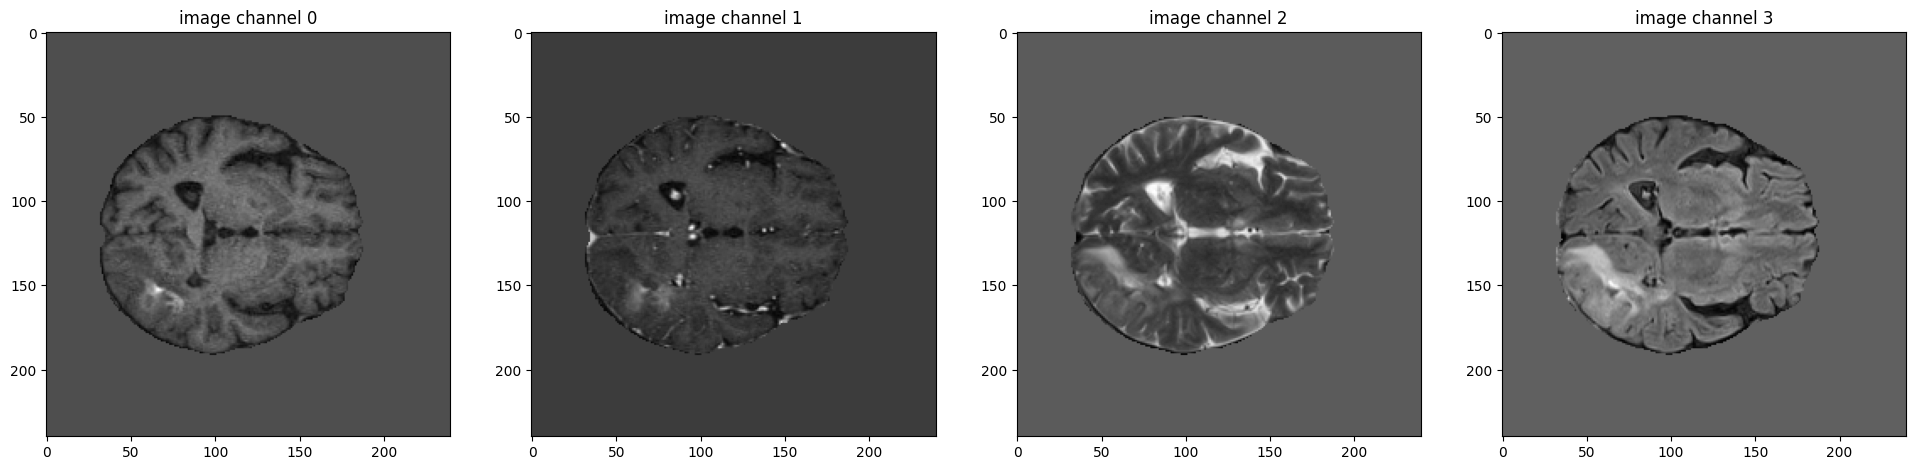

In [ ]:
import matplotlib.pyplot as plt

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

with torch.no_grad():

    val_data_dict = get_data(data_dir)[0]
    val_data_dict = transform(val_data_dict)
    val_input = val_data_dict['image']
    val_output = dropout_predictions
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_input[i, :, :, 70], cmap="gray")
    plt.show()


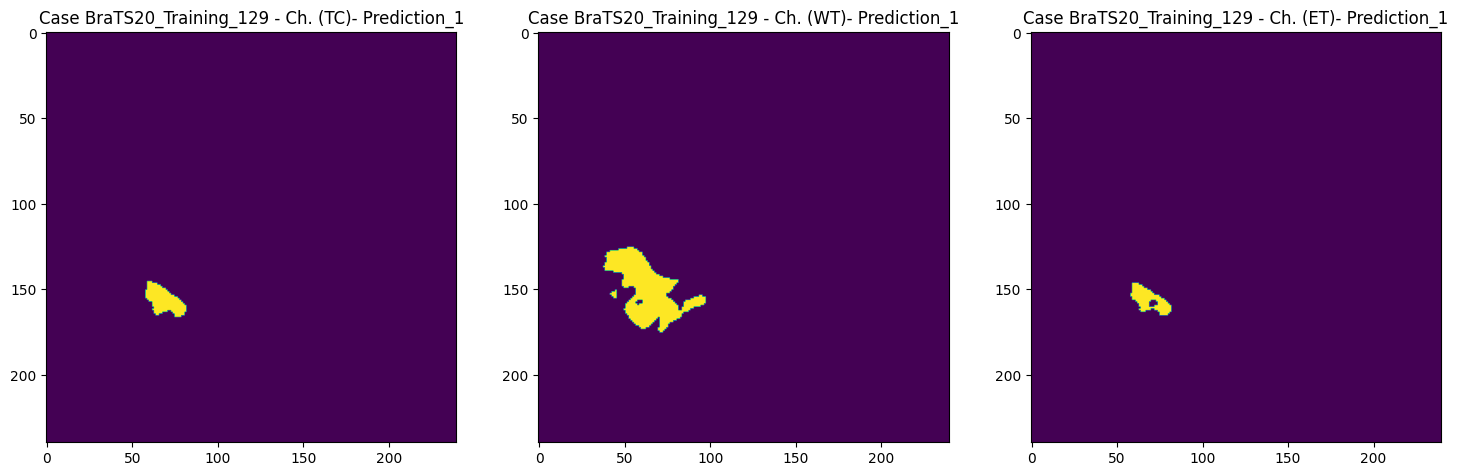

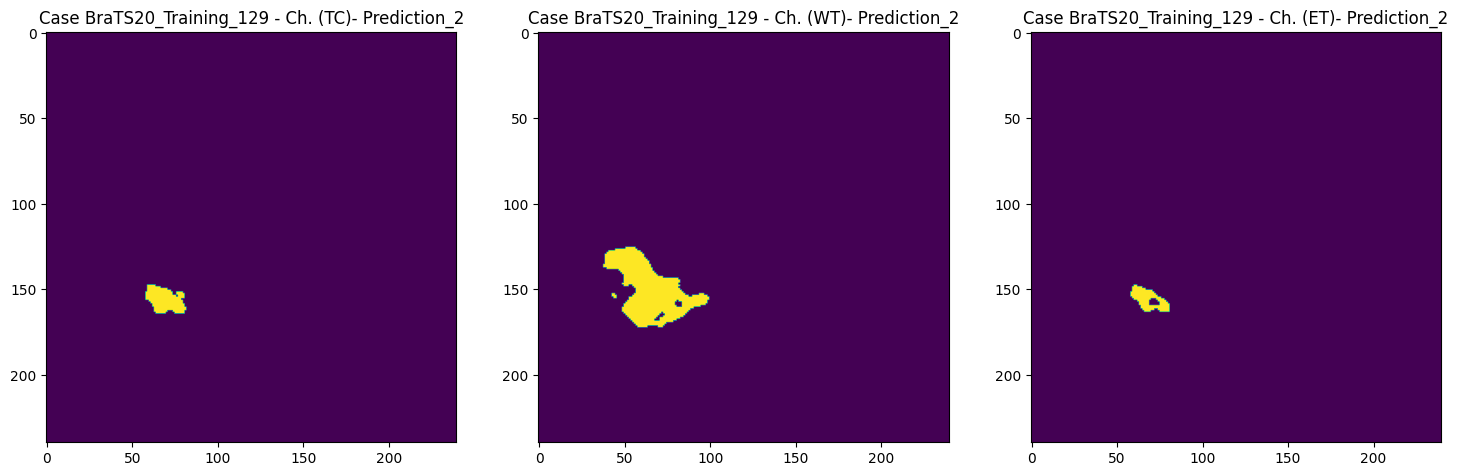

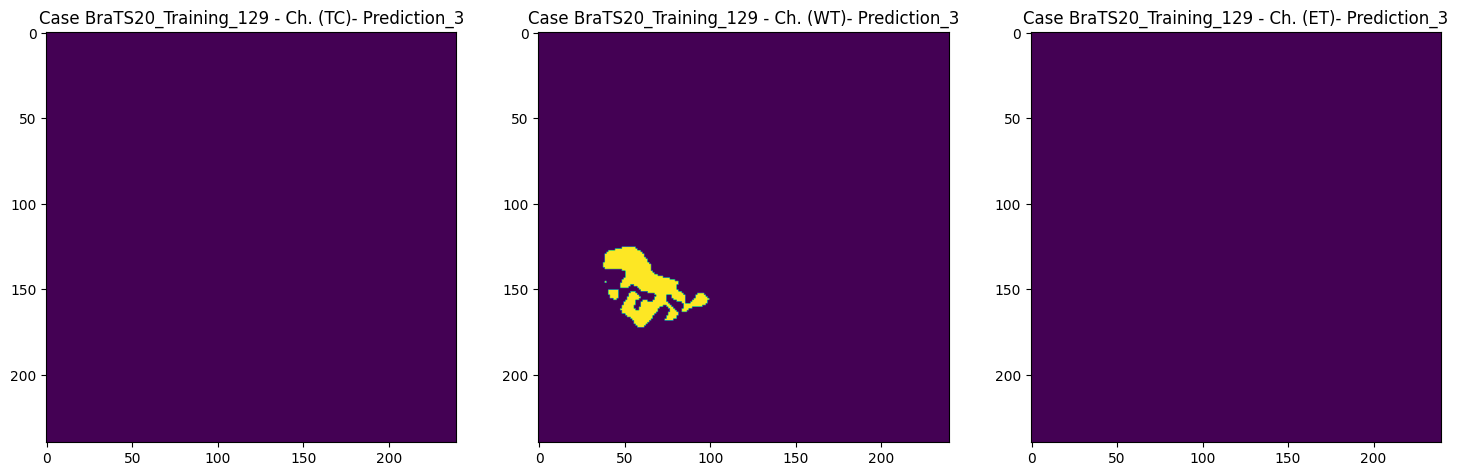

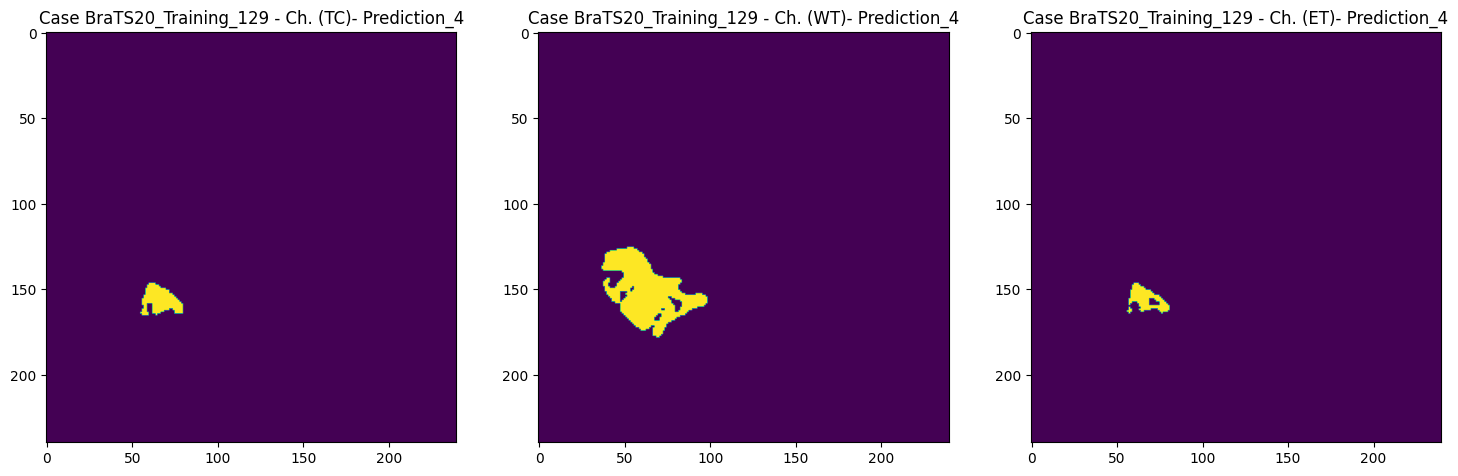

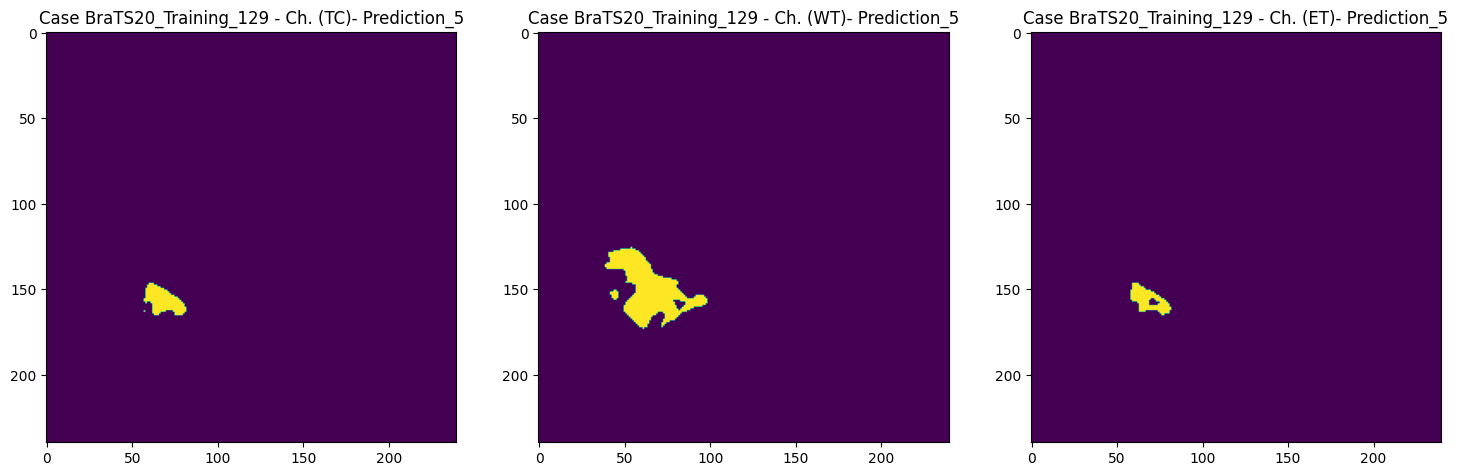

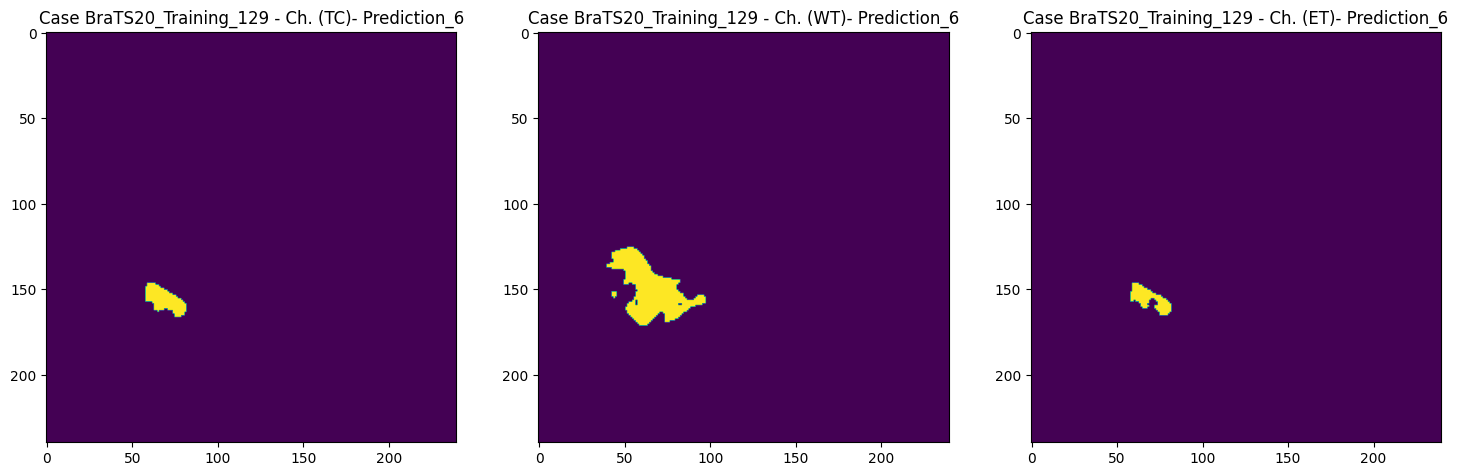

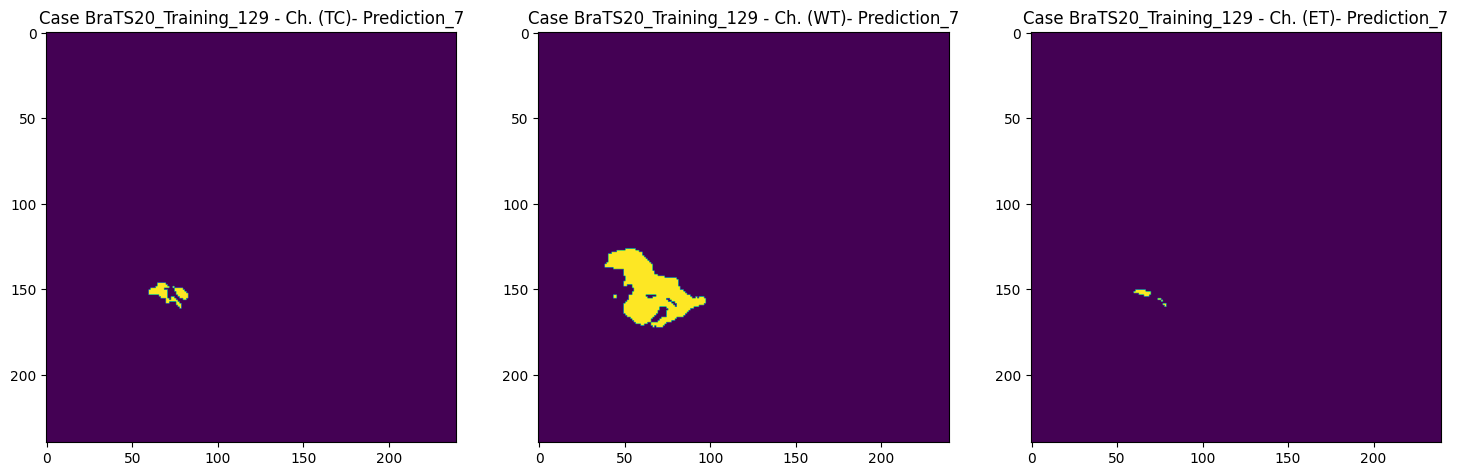

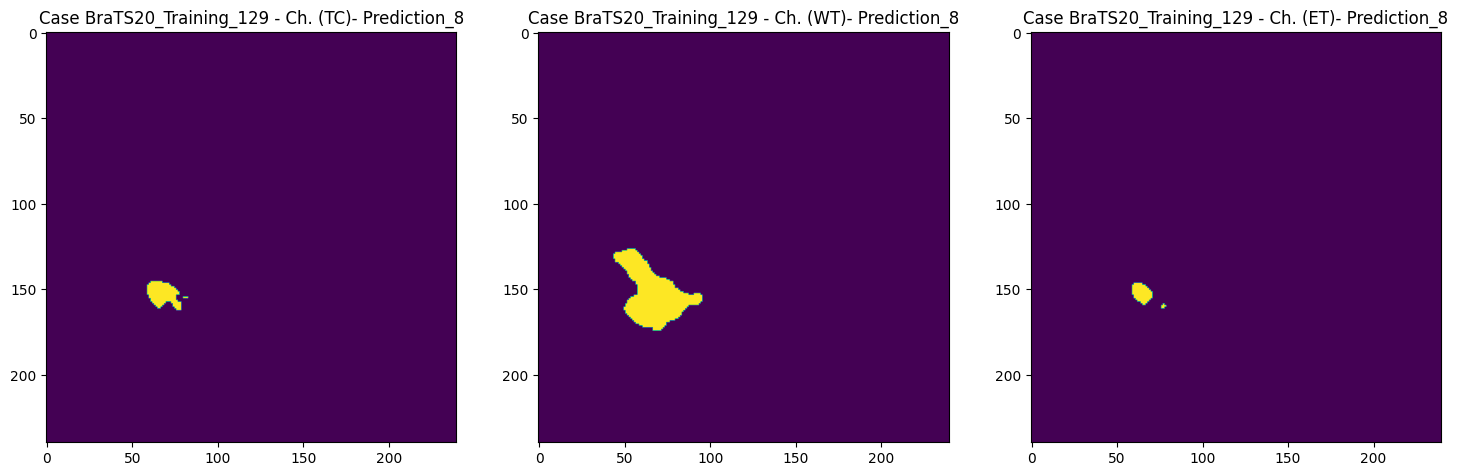

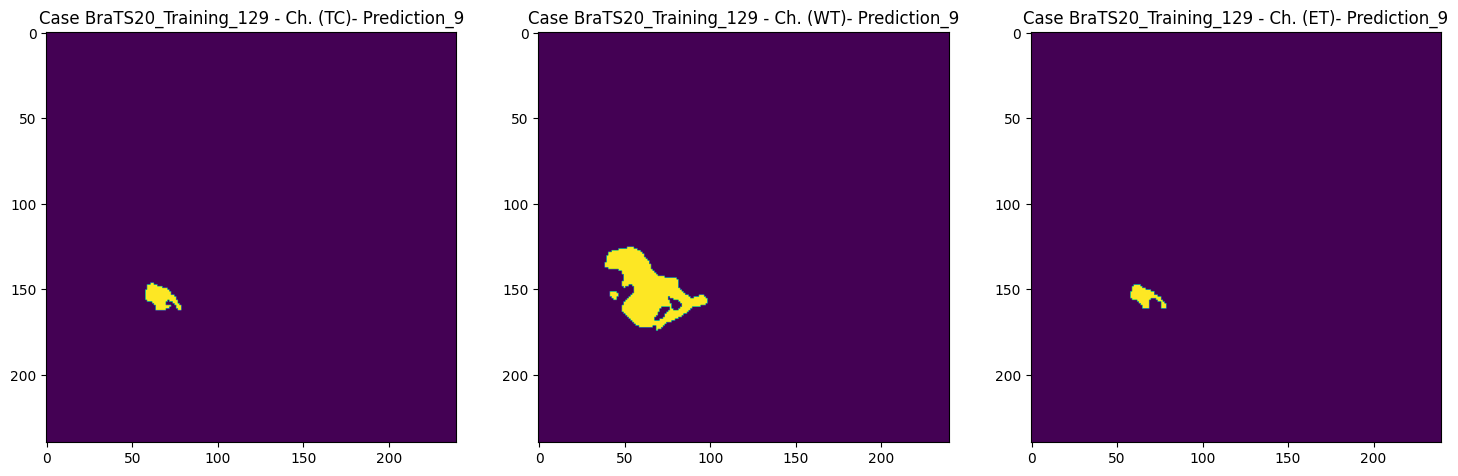

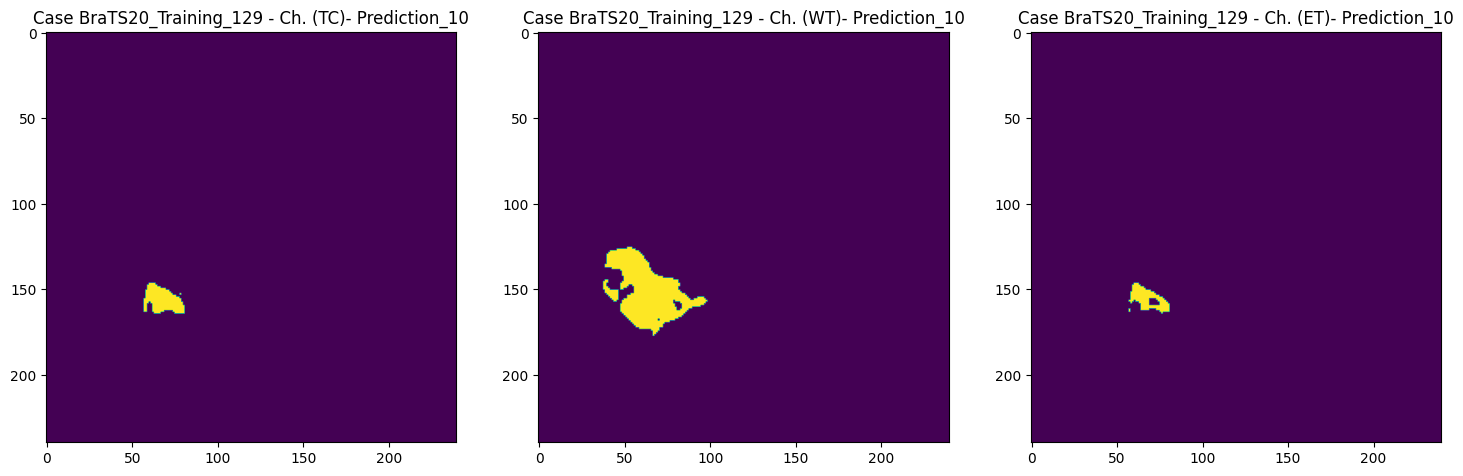

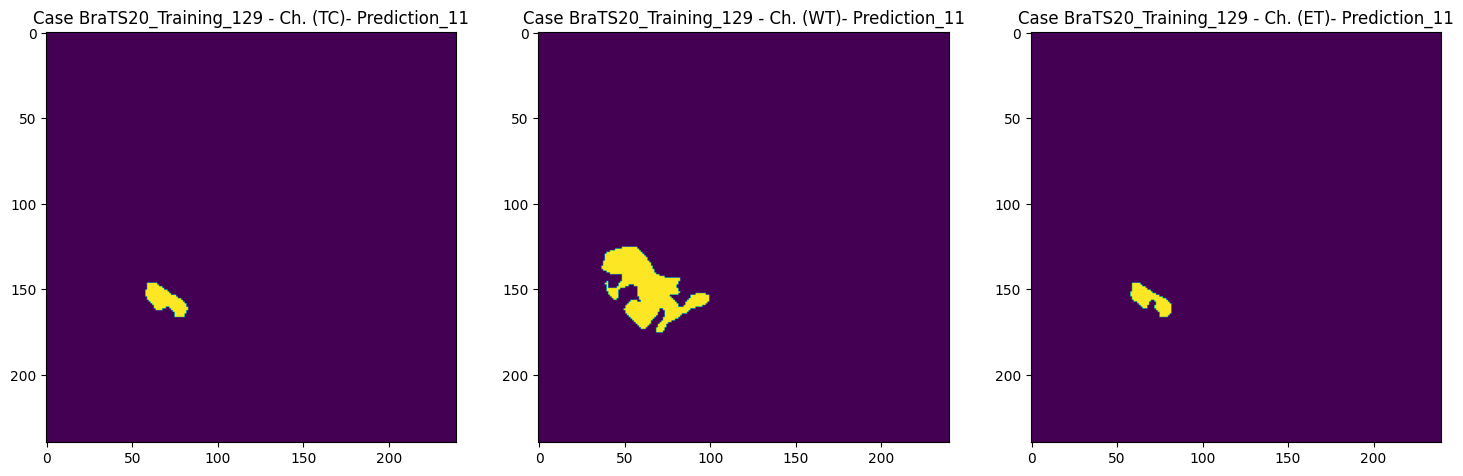

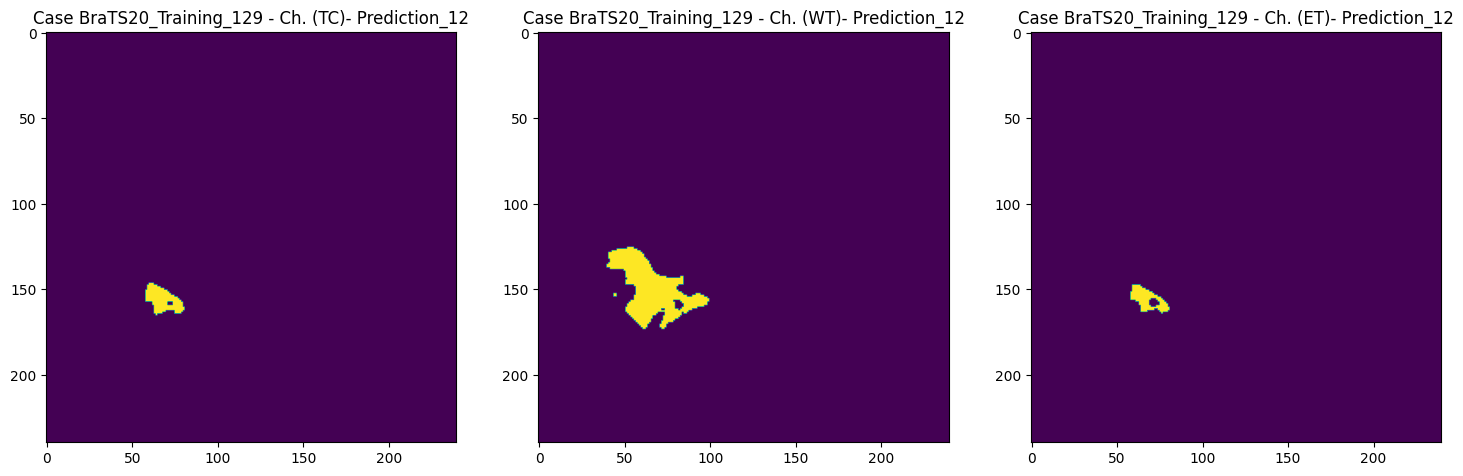

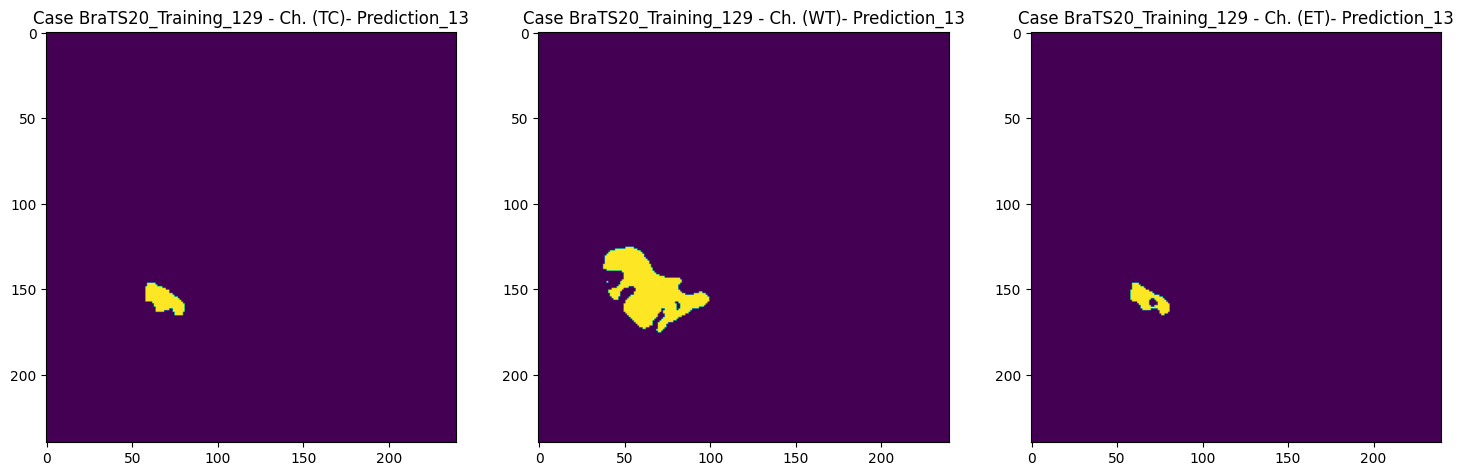

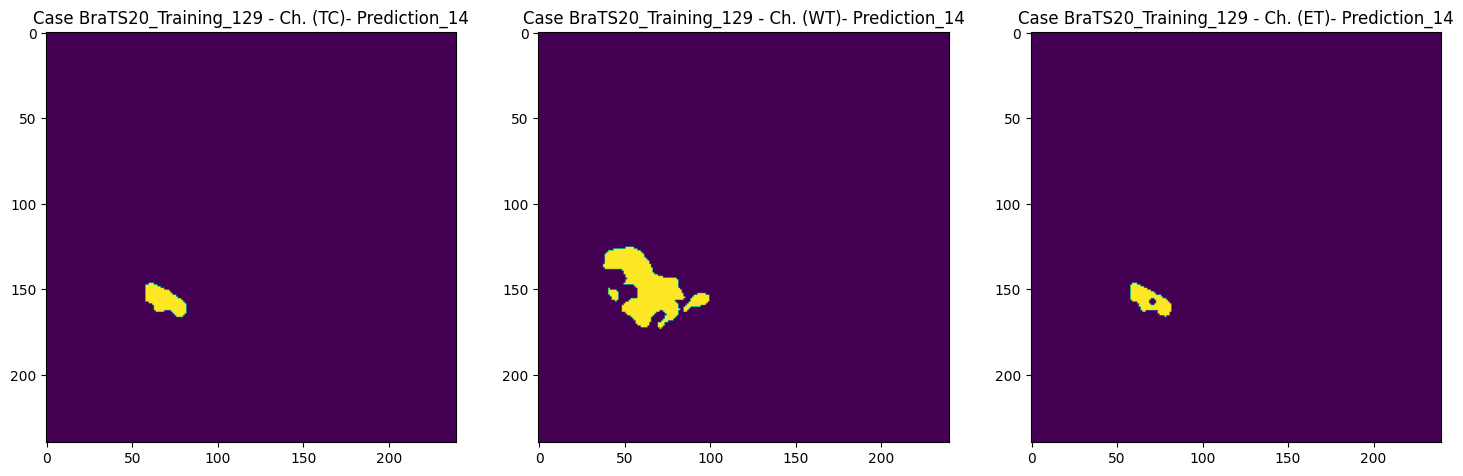

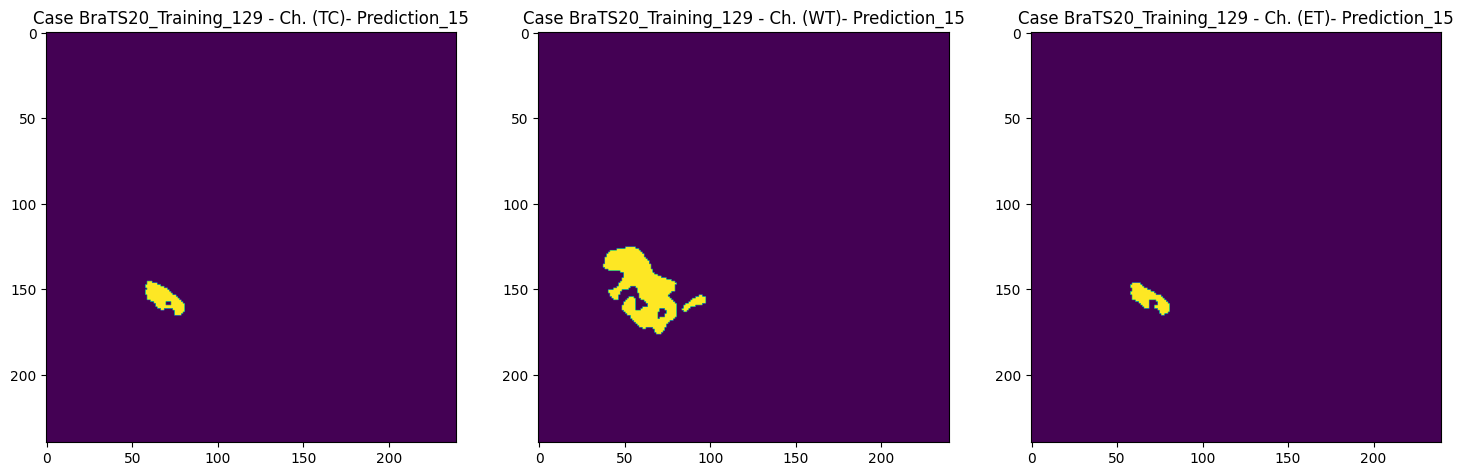

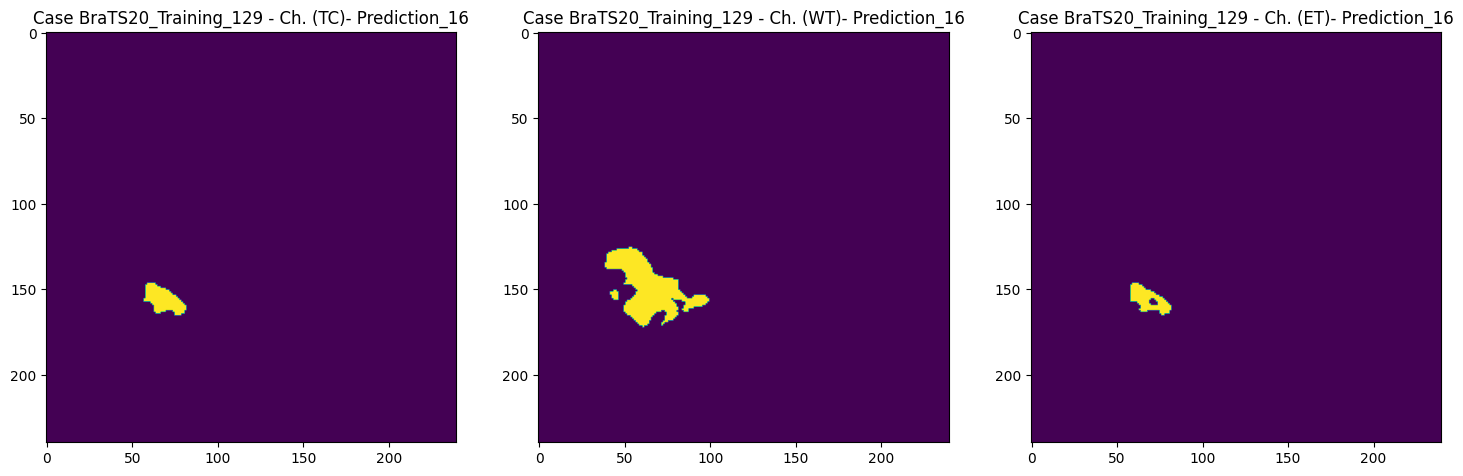

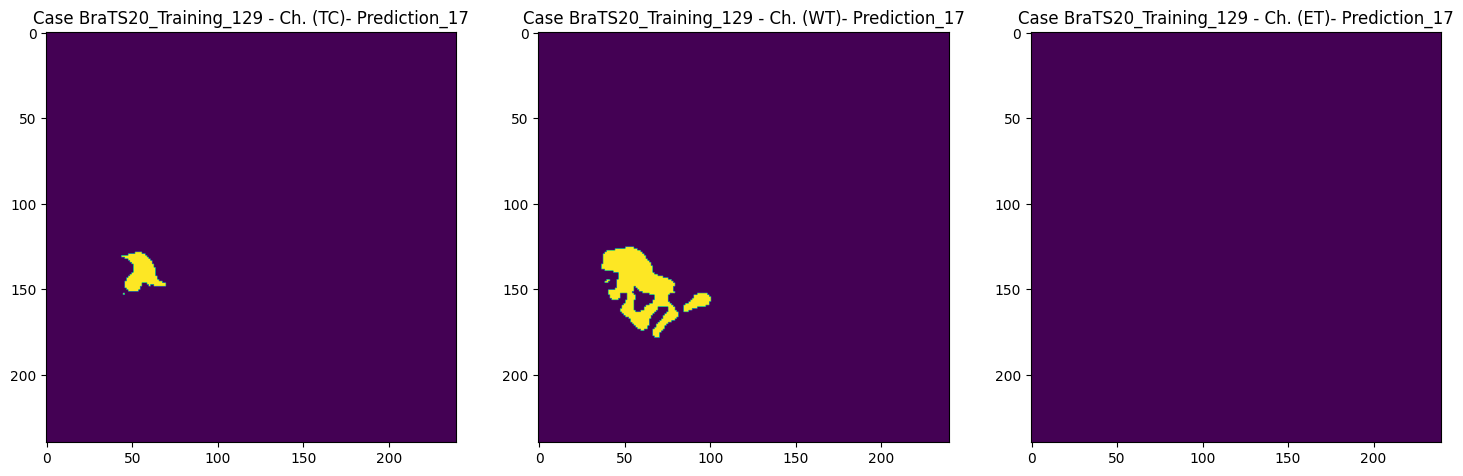

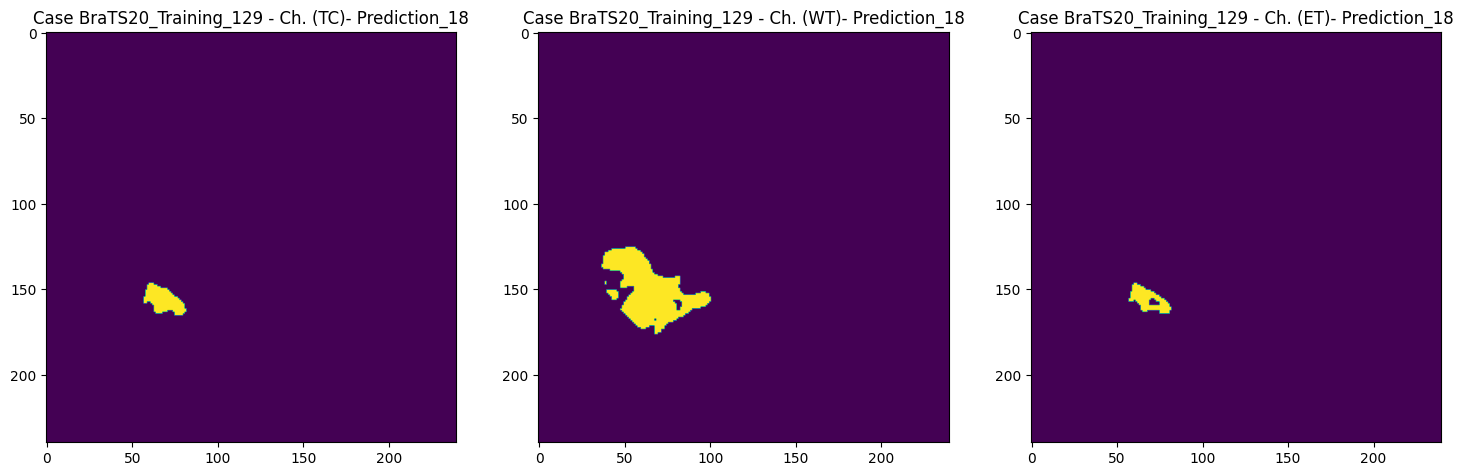

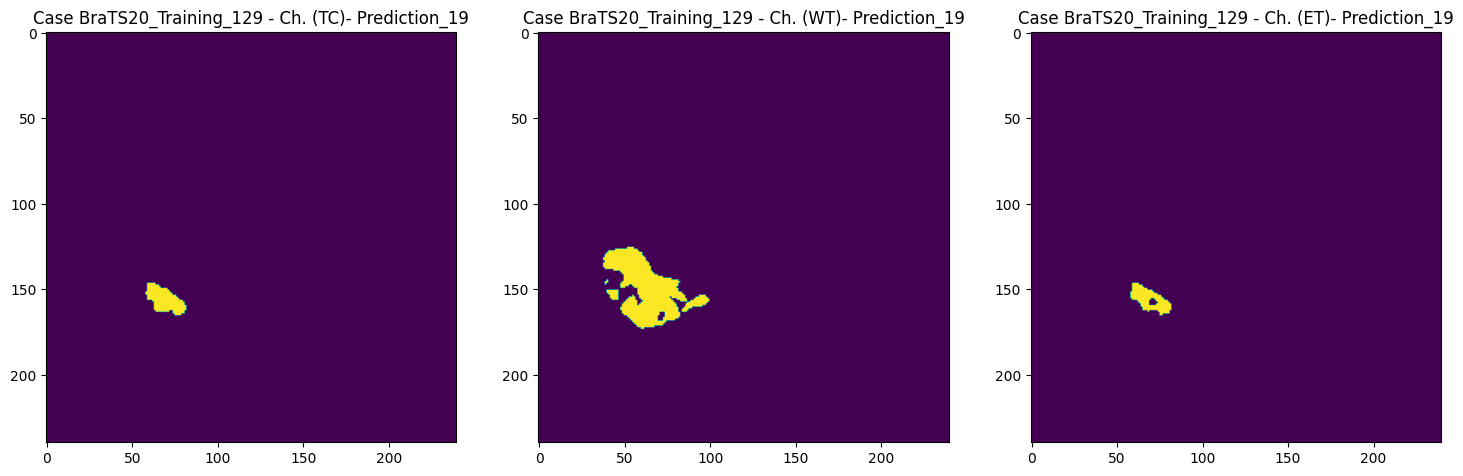

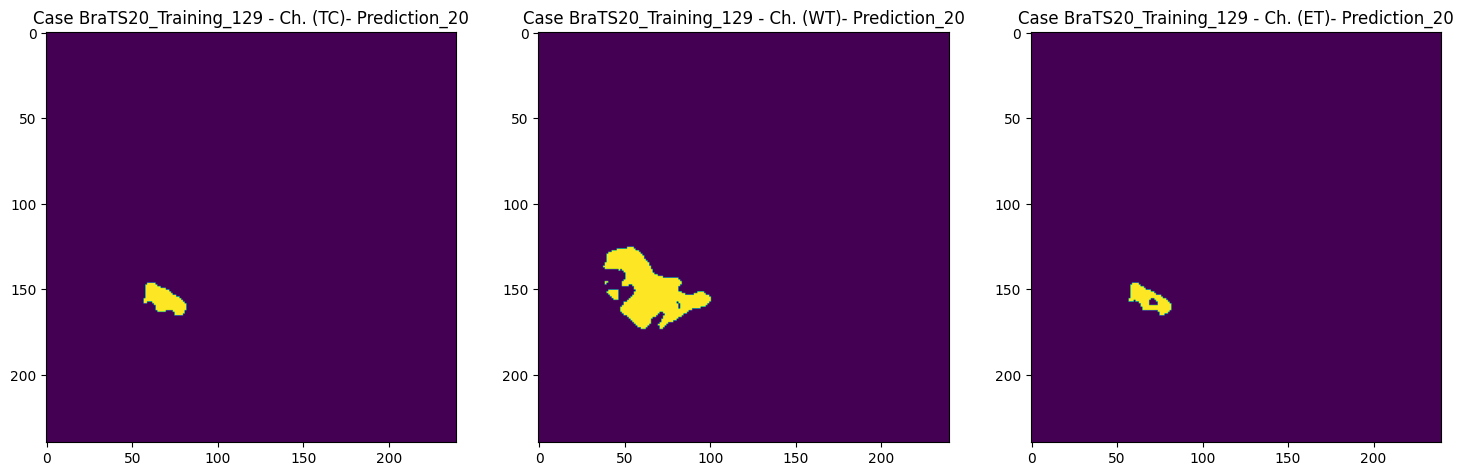

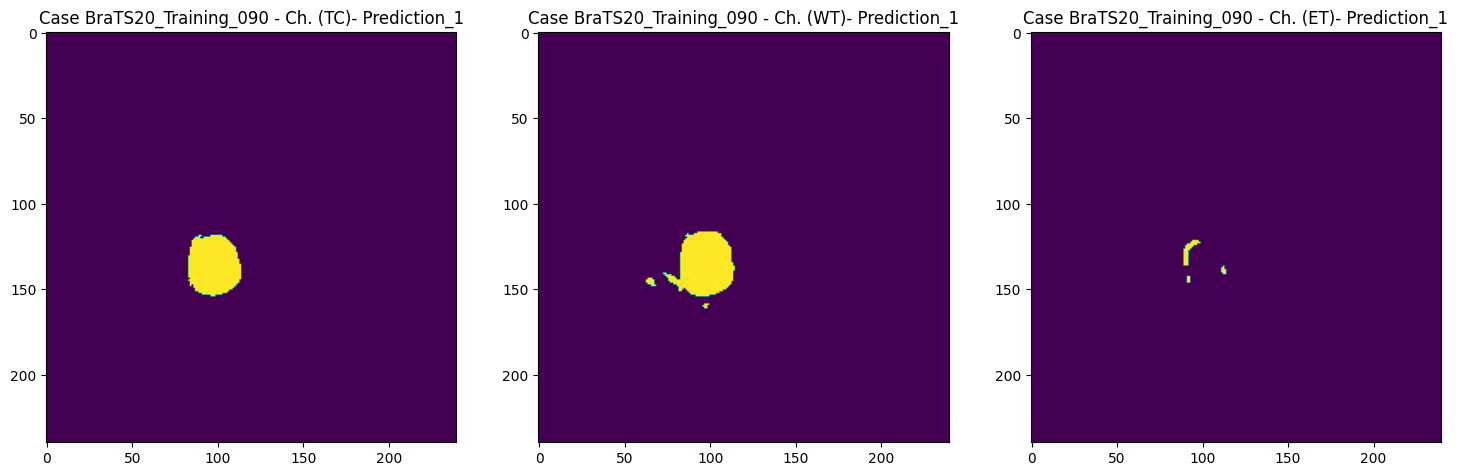

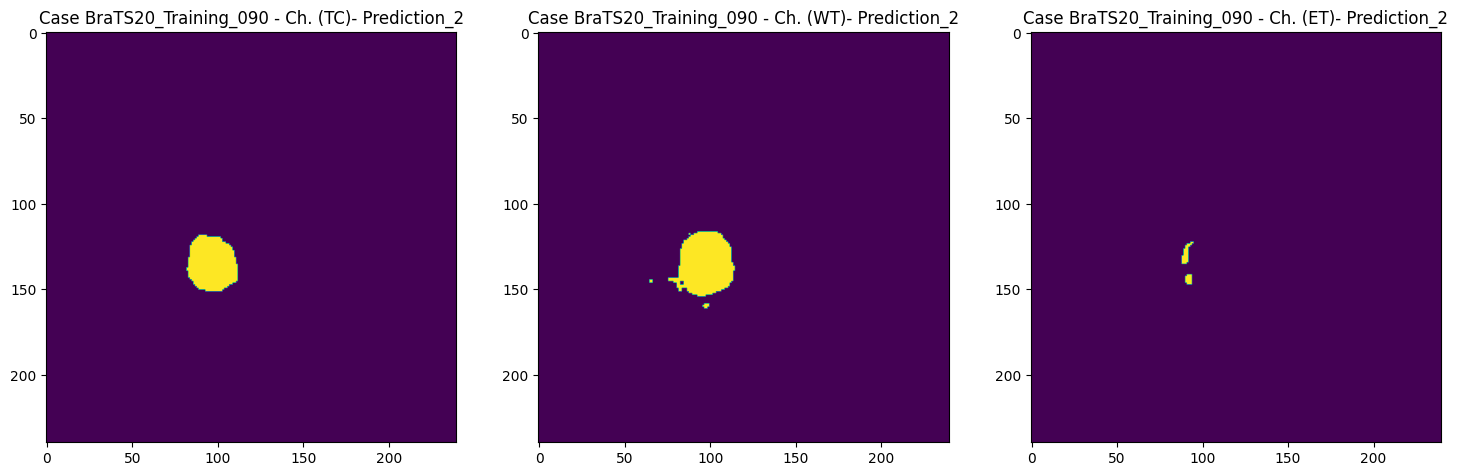

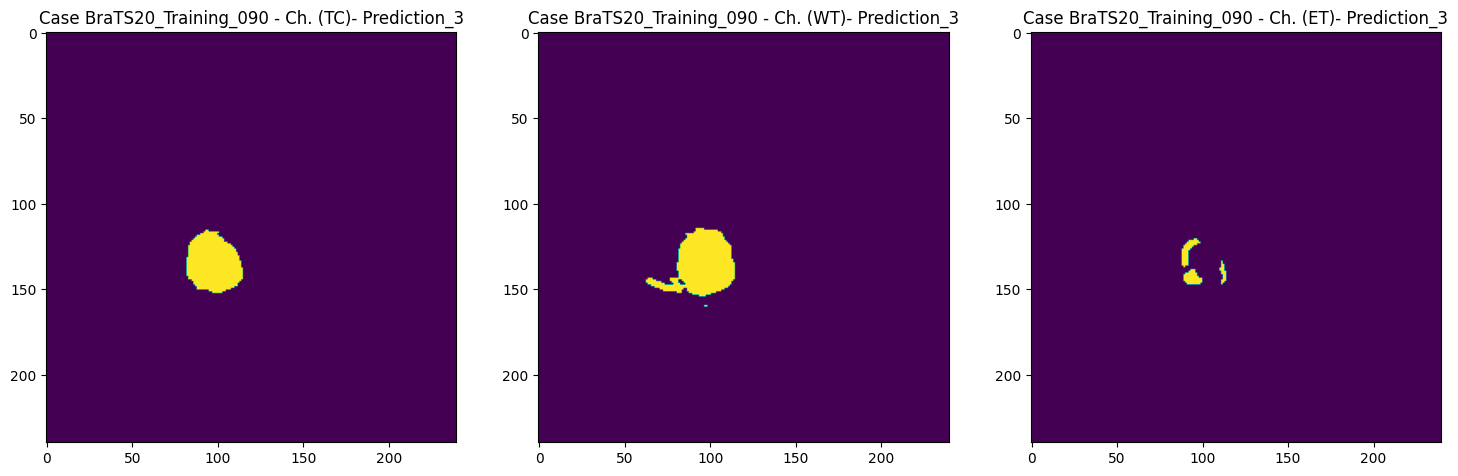

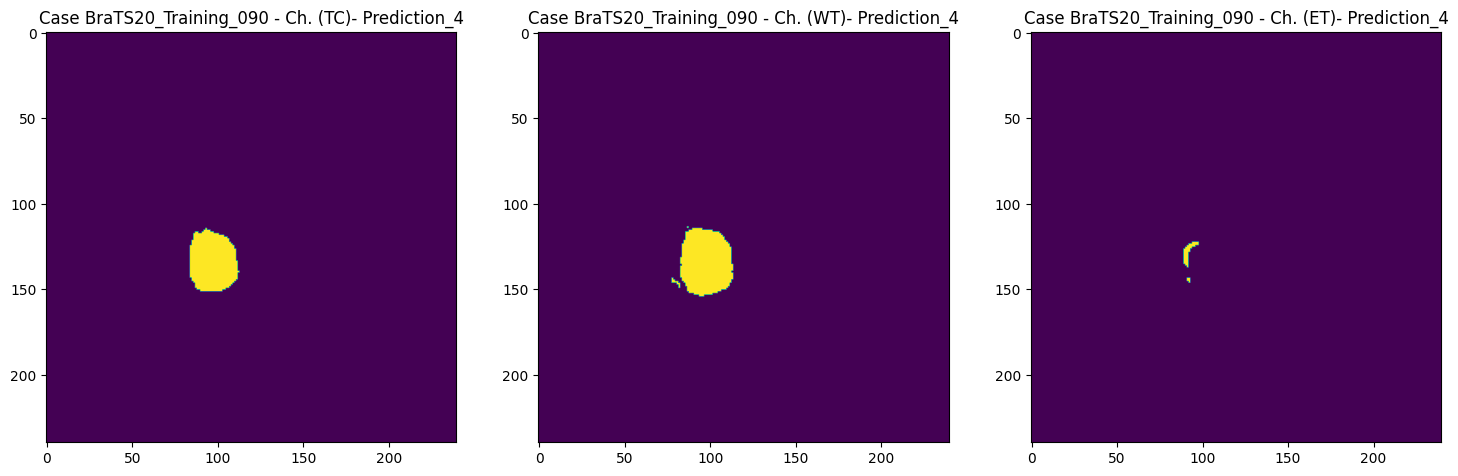

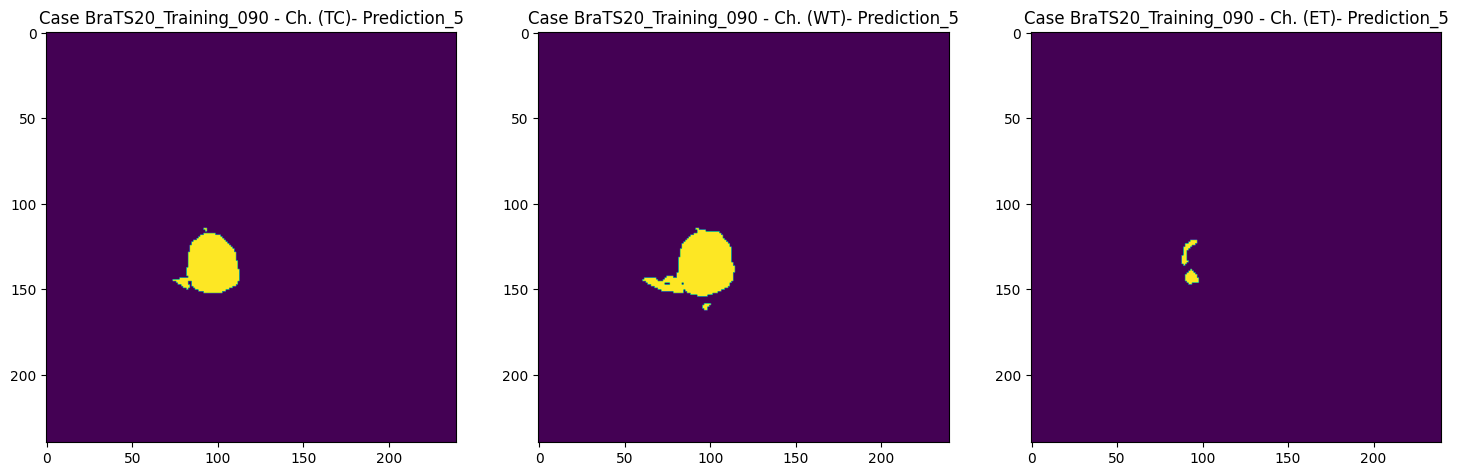

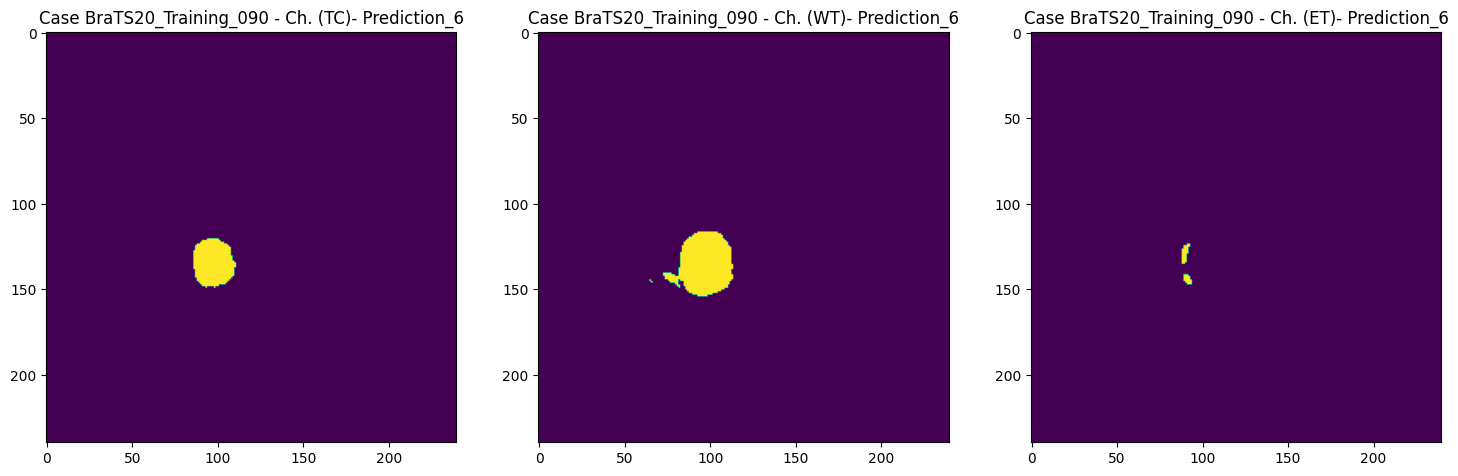

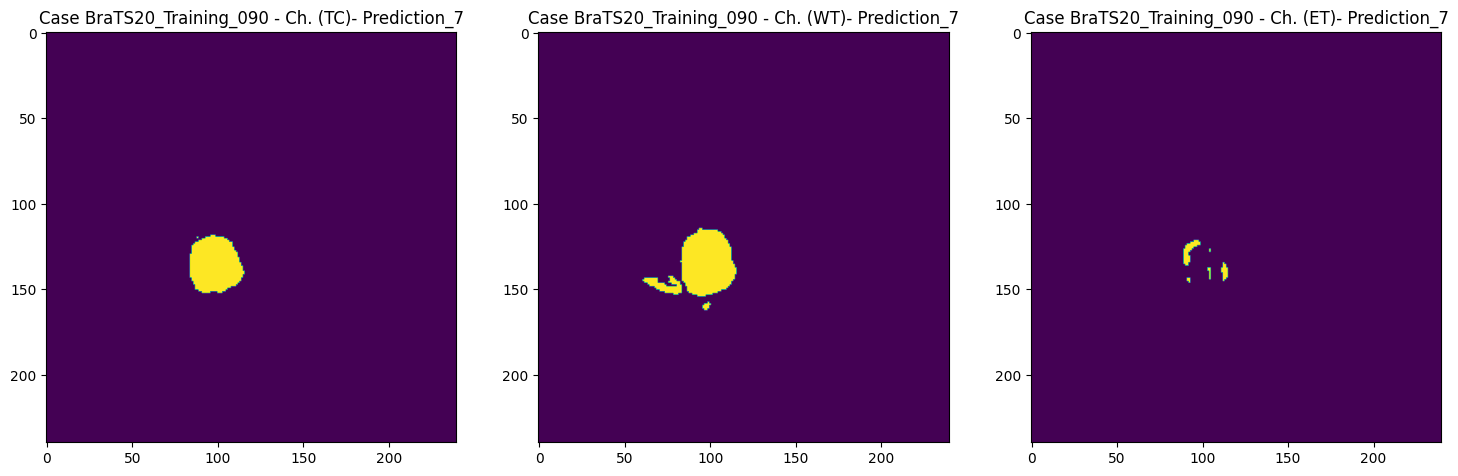

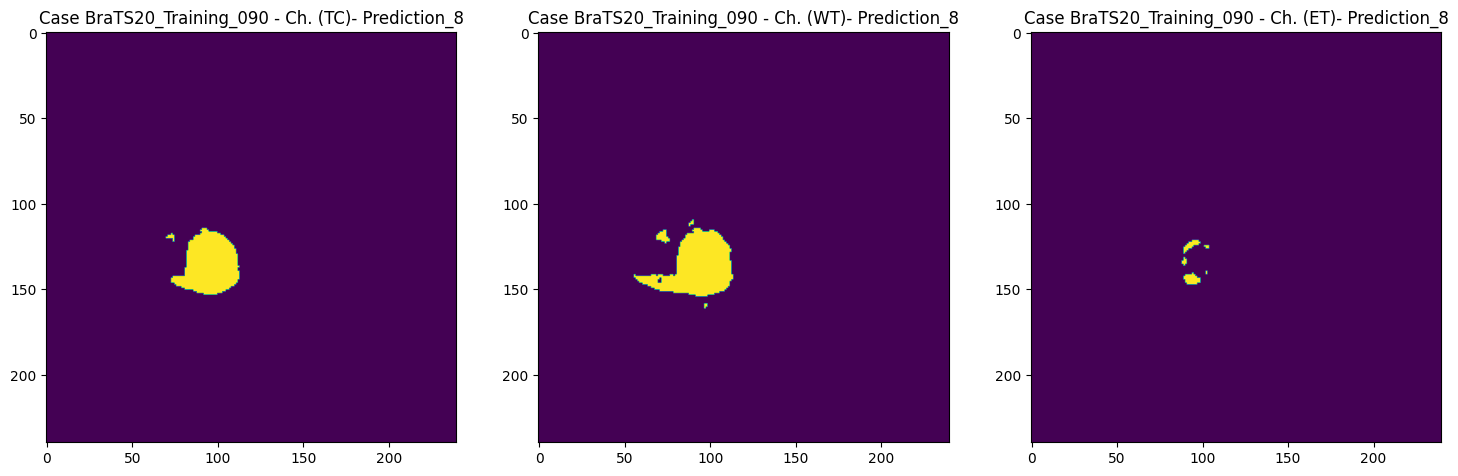

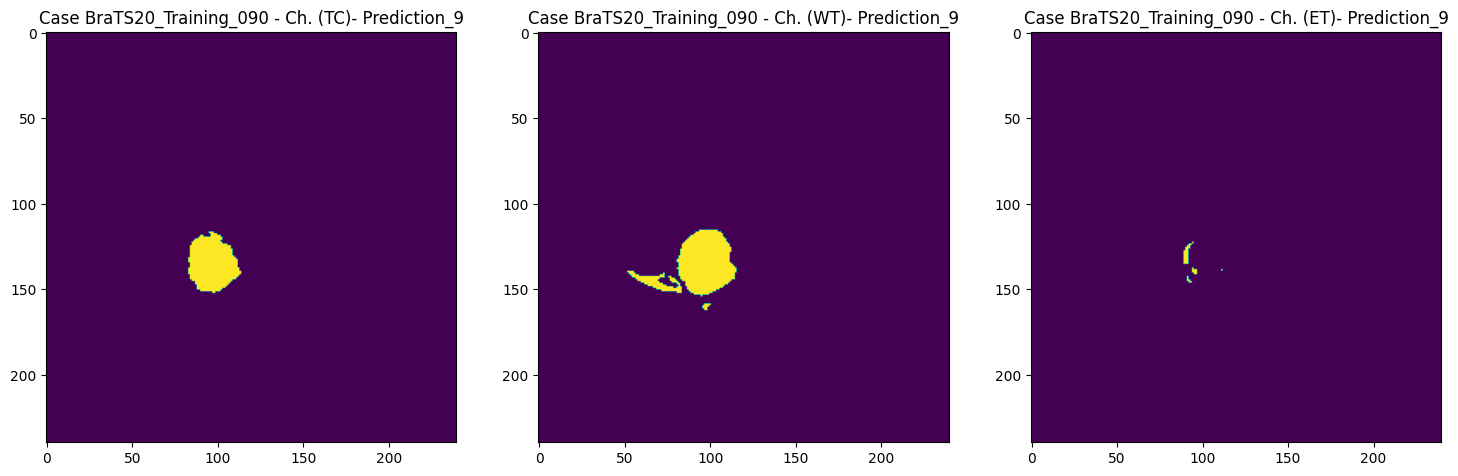

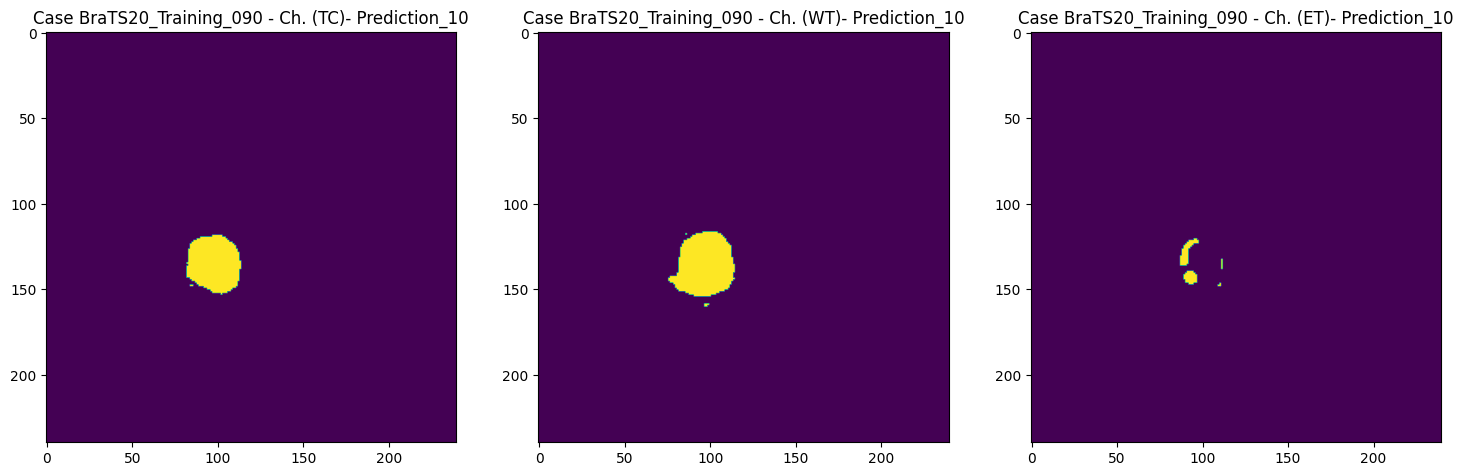

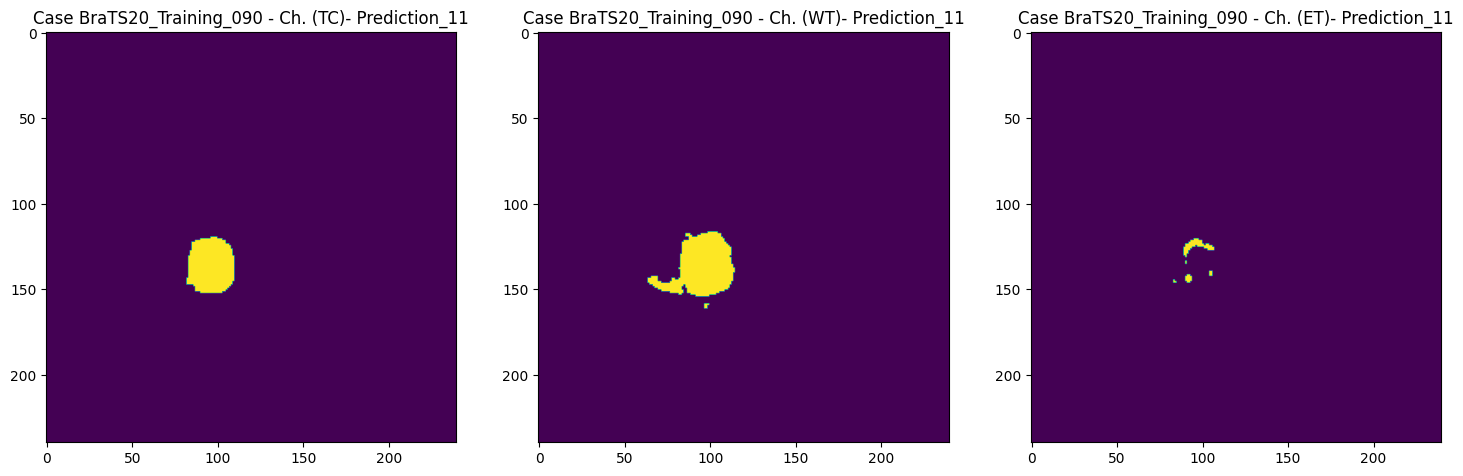

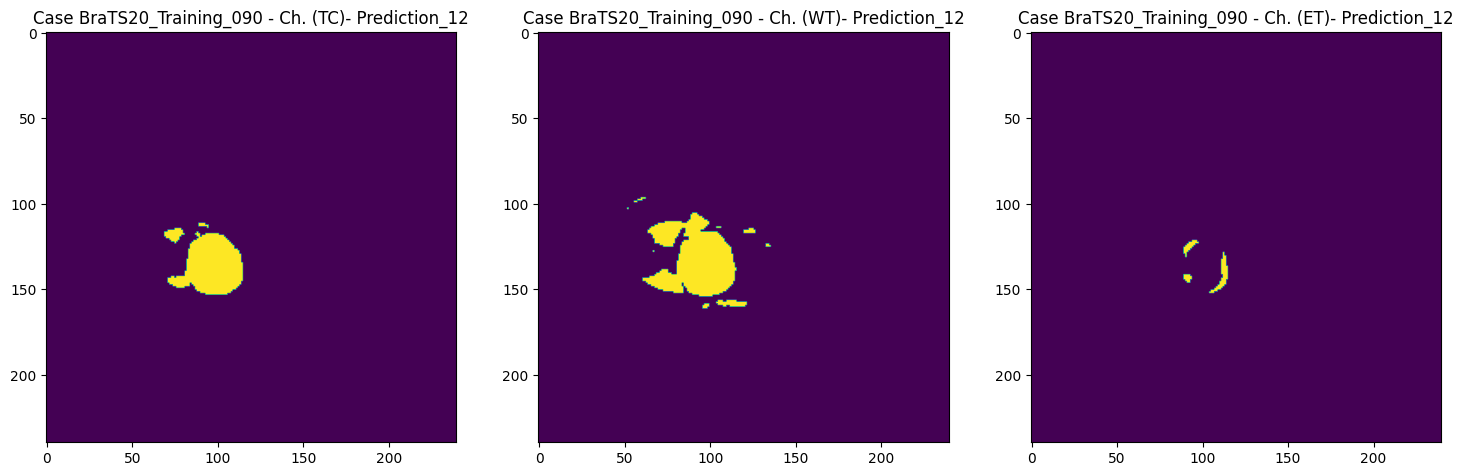

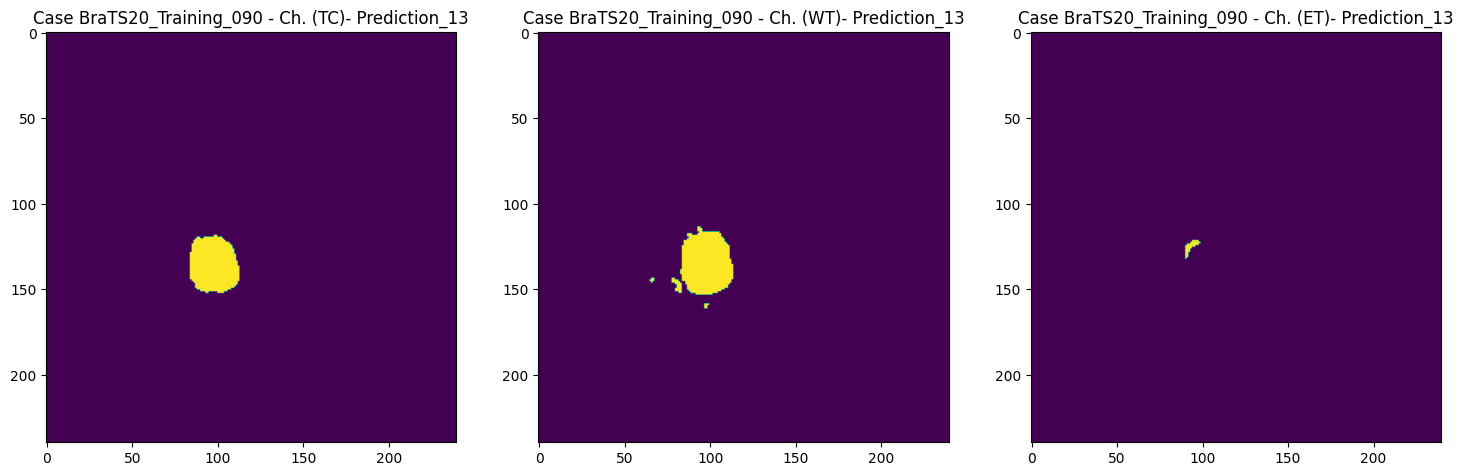

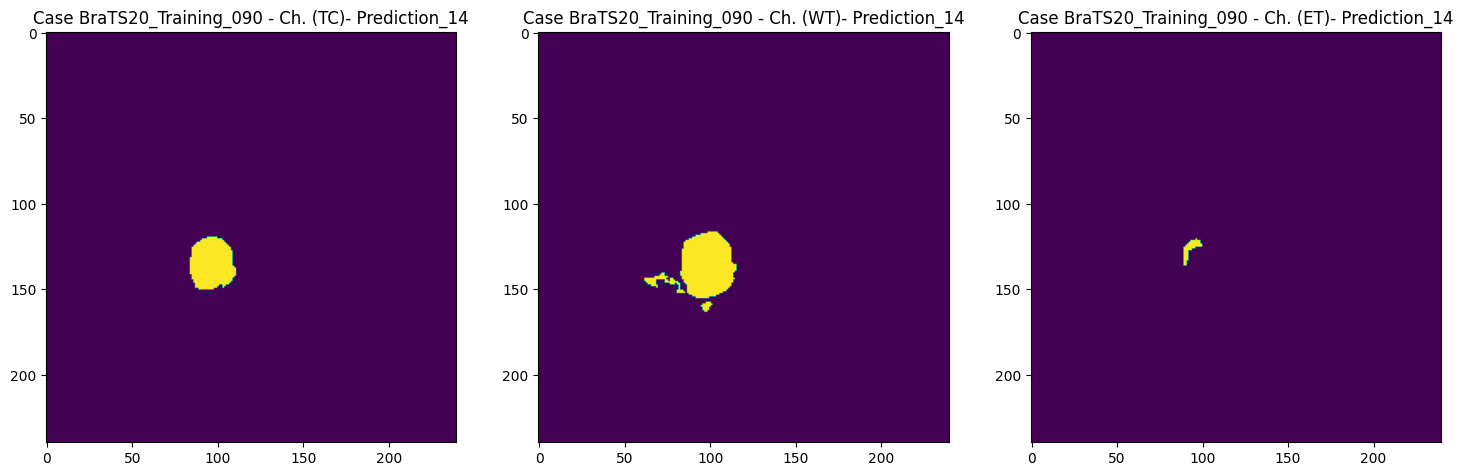

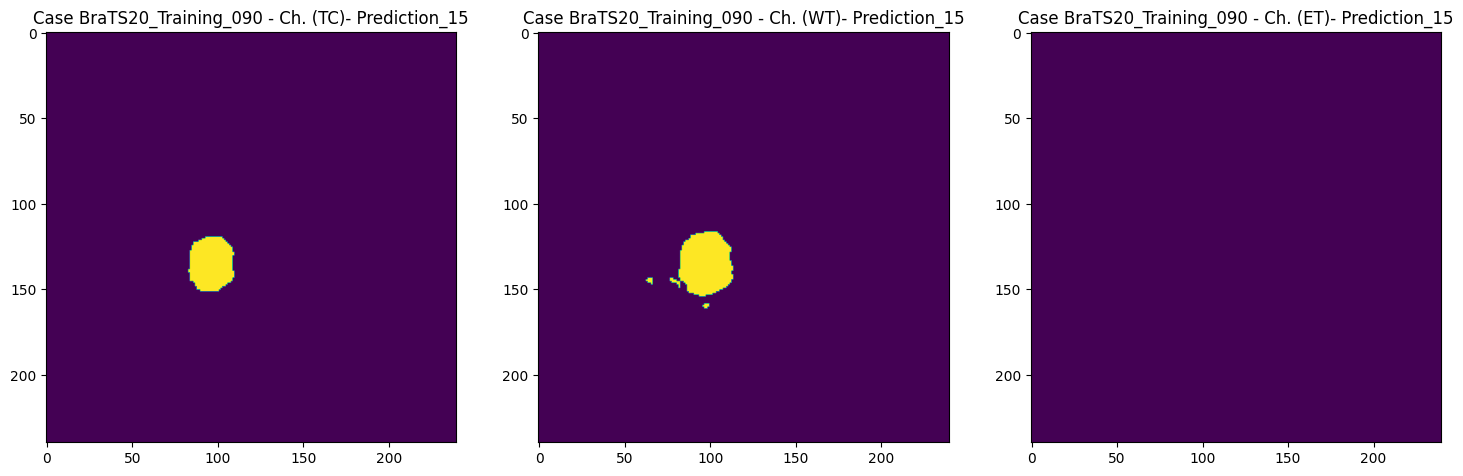

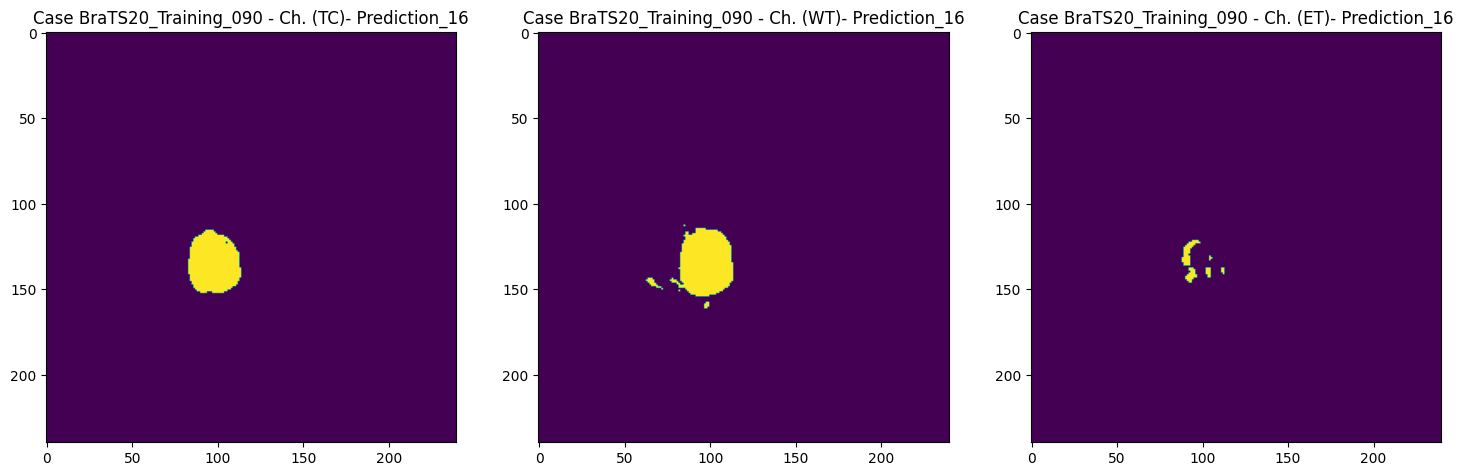

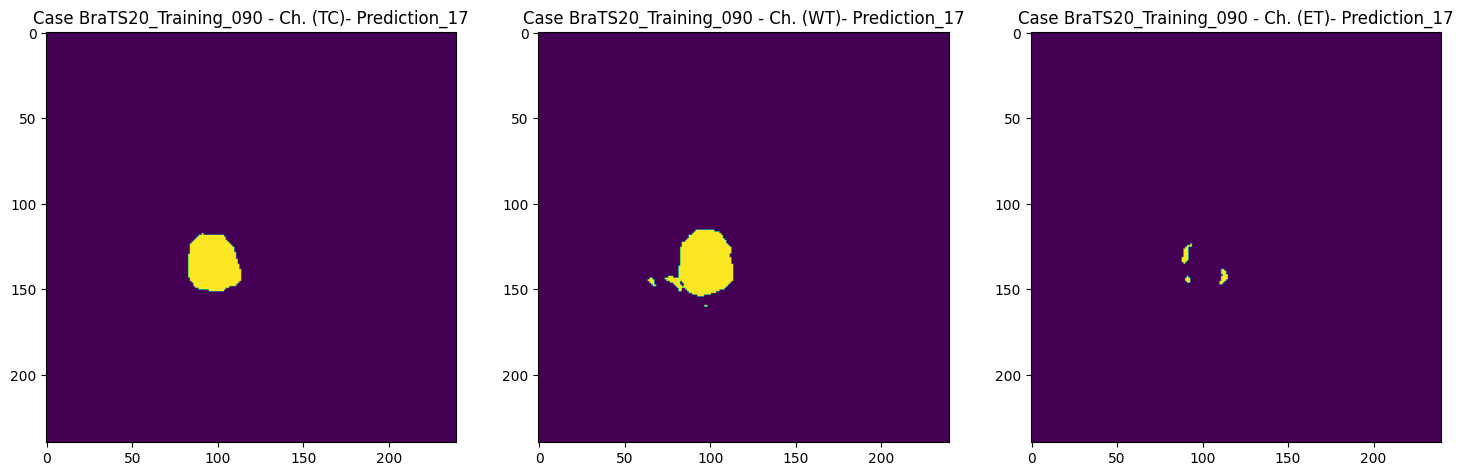

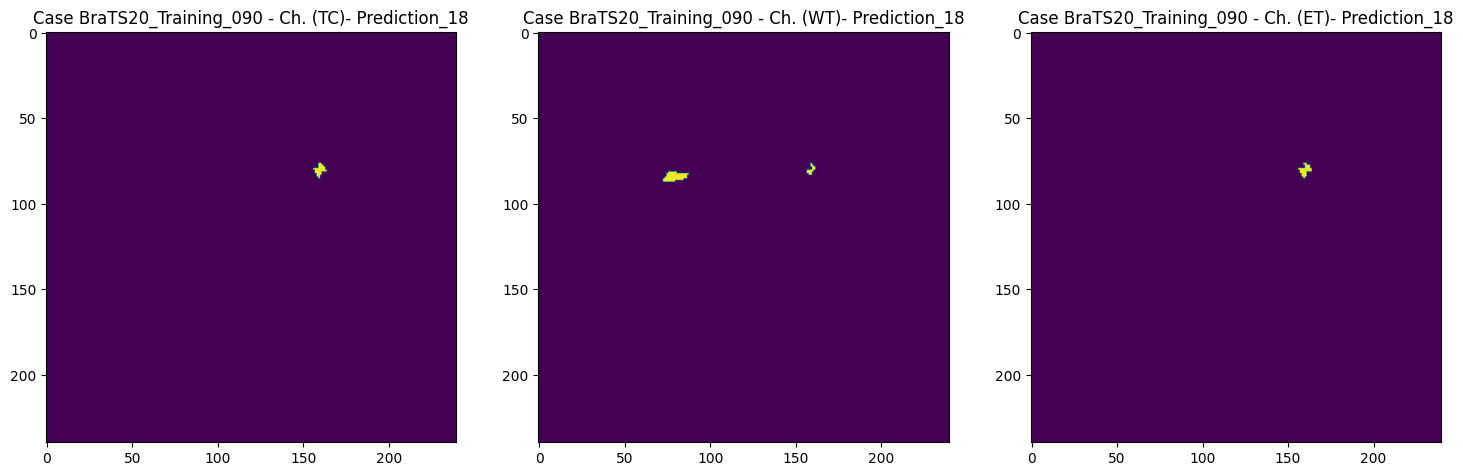

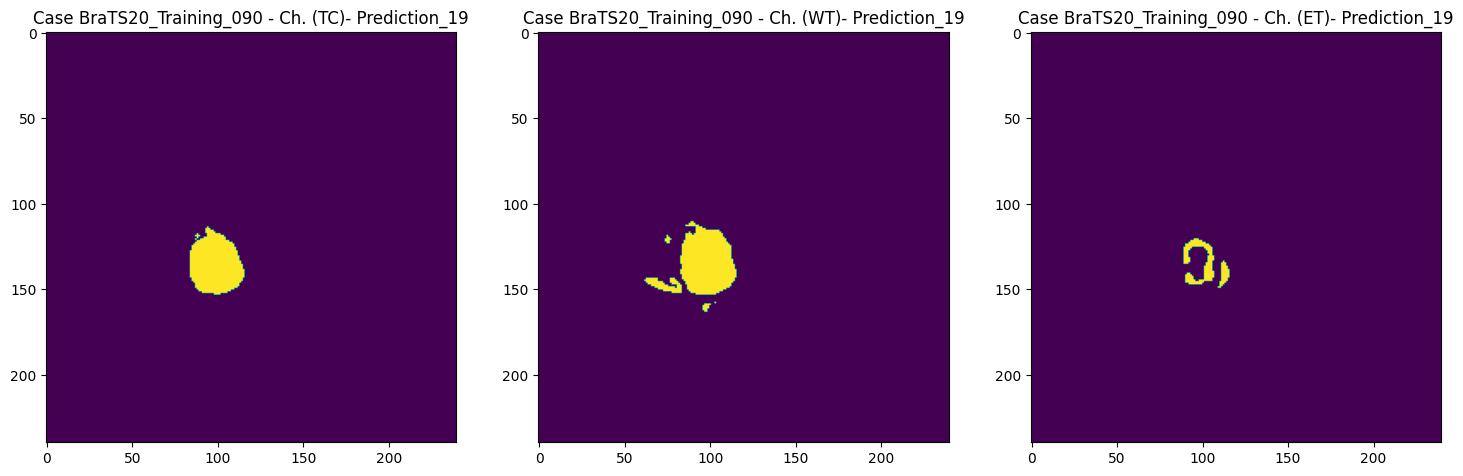

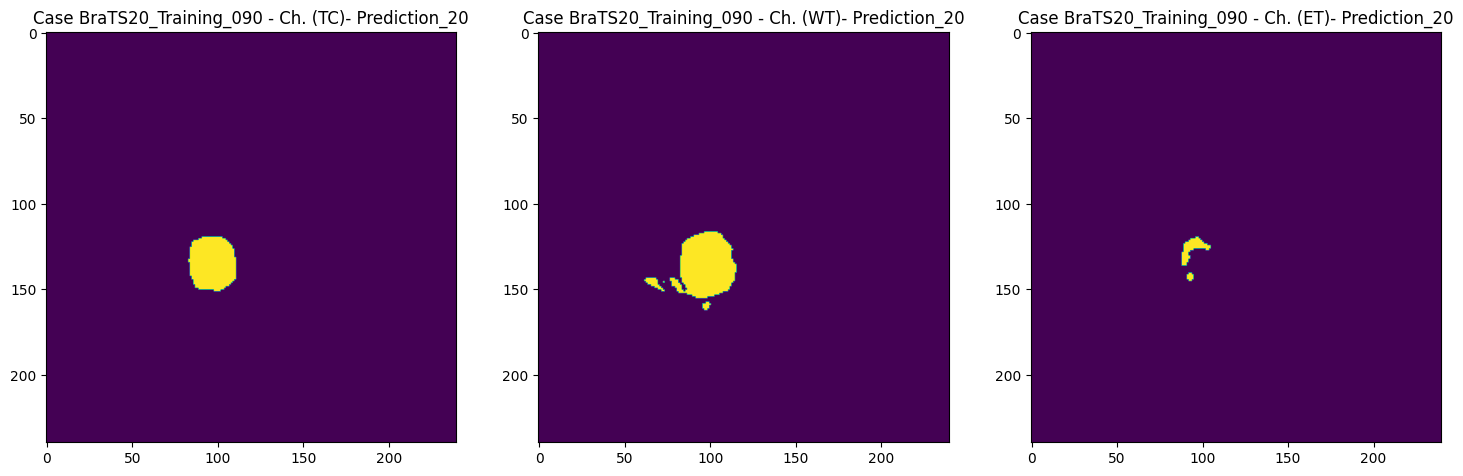

In [ ]:
import matplotlib.pyplot as plt
channel_names = ["TC", "WT", "ET"]
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

with torch.no_grad():

    data = get_data(data_dir)
    num_cases = dropout_predictions.shape[1]

    for case_idx, case_data in enumerate(data[:num_cases]):
        val_input = case_data['image']
        case_name = case_data['folder_name']

        for pass_idx in range(dropout_predictions.shape[0]):
            val_output = dropout_predictions[pass_idx, case_idx]
            val_output = post_trans(val_output)

            plt.figure(f"Case {case_idx + 1} - {case_name} - output_pass_{pass_idx}", (18, 6))
            for i in range(3):
                plt.subplot(1, 3, i + 1)
                plt.title((f"Case {case_name} - Ch. ({channel_names[i]})- Prediction_{pass_idx+1}"))
                #print(torch.max(val_output[i, :, :, 70].detach().cpu()))
                plt.imshow(val_output[i, :, :, 70])
            plt.show()


Label for case: BraTS20_Training_129


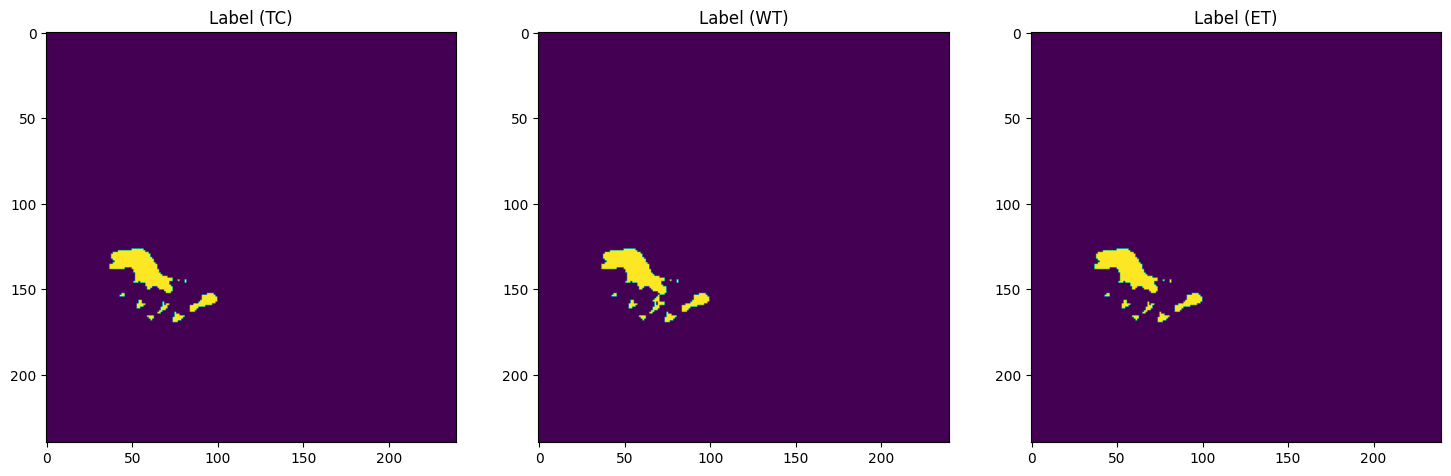

Label for case: BraTS20_Training_090


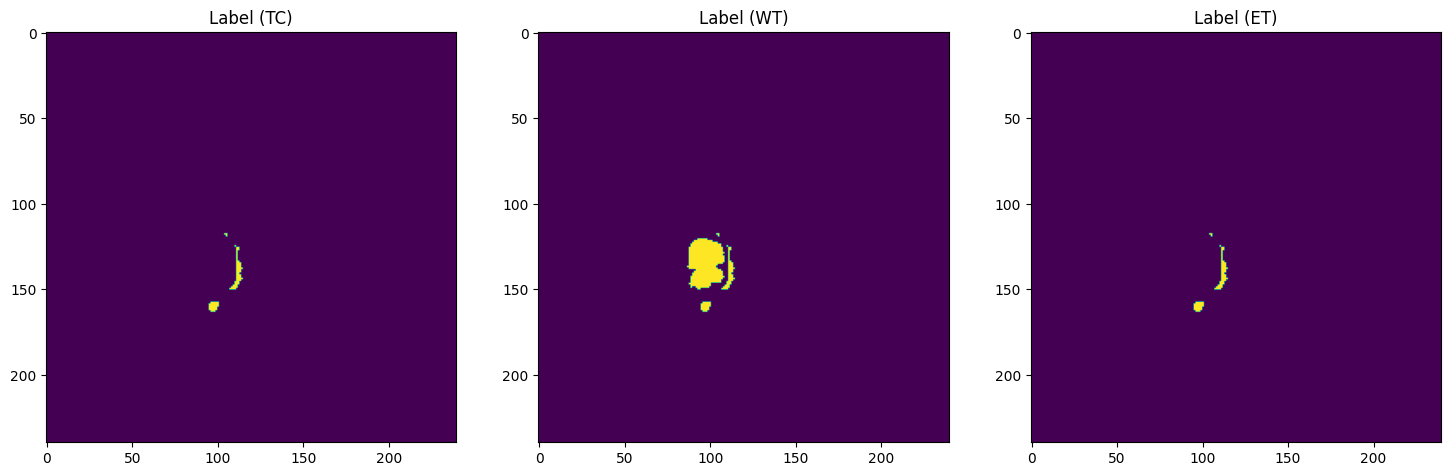

In [ ]:
###### Label Visualization

val_input_tensor = val_data_dict['image']
image = val_input_tensor.cpu().numpy()
plt.imshow(image[3, :, :, 70], cmap="gray")

import matplotlib.pyplot as plt

data_list = get_data(data_dir)
label_transform = ConvertToMultiChannelBasedOnBratsClassesd(keys="label")



for idx, sample in enumerate(data_list):
    if idx >= n_samples:
        break

    label_file = sample["label"]
    label_data = nib.load(label_file).get_fdata()

    label_dict = label_transform({"label": torch.tensor(label_data)})
    label_tensor = label_dict["label"]

    case_name = sample["label"].split('/')[-2]
    print(f"Label for case: {case_name}")

    plt.figure(f"Label for {case_name}", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title((f"Label ({channel_names[i]})"))
        #print(torch.max(label_tensor[i, :, :, 70].detach().cpu()))
        plt.imshow(image[i, :, :, 70], cmap="gray")
        plt.imshow(np.rot90(label_tensor[i, :, :, 70].detach().cpu(), k=2))
    plt.show()


Label for case: BraTS20_Training_129


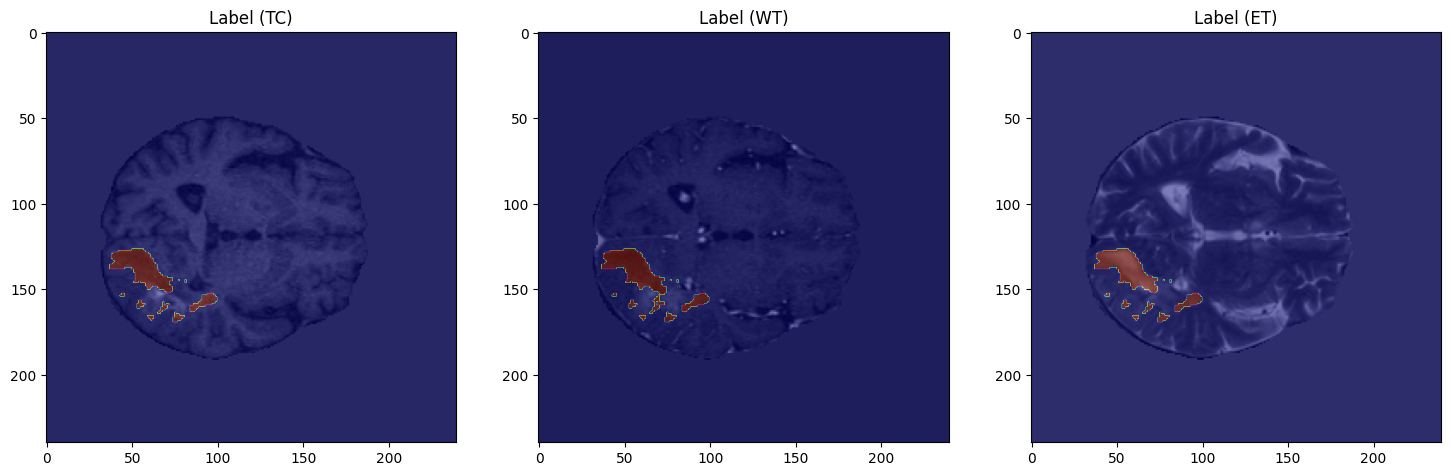

Label for case: BraTS20_Training_090


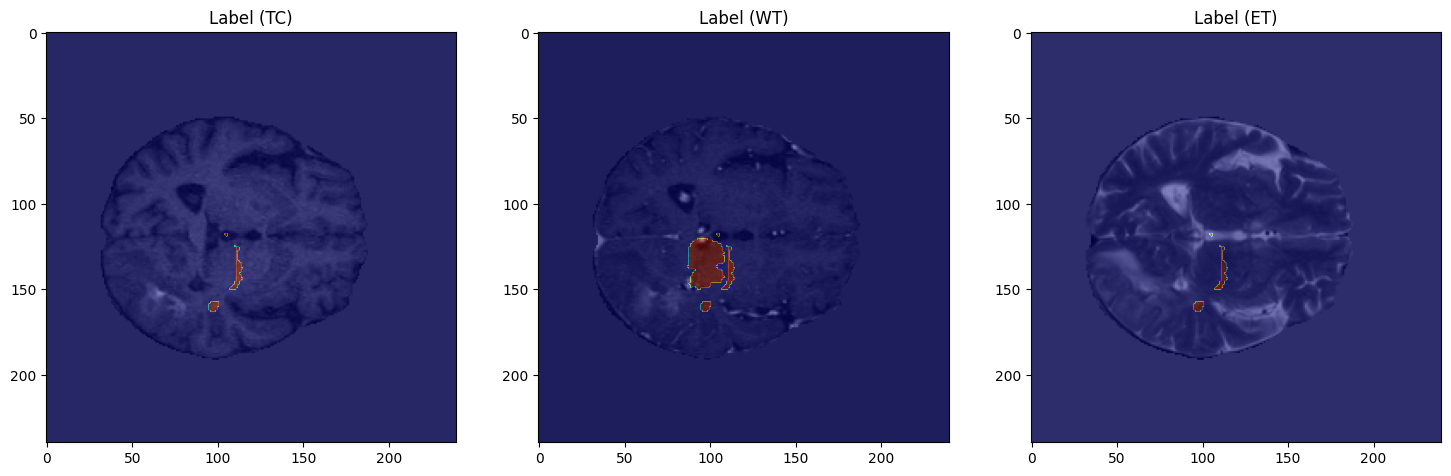

In [ ]:
import matplotlib.pyplot as plt

data_list = get_data(data_dir)
label_transform = ConvertToMultiChannelBasedOnBratsClassesd(keys="label")

for idx, sample in enumerate(data_list):
    if idx >= n_samples:
        break

    label_file = sample["label"]
    label_data = nib.load(label_file).get_fdata()

    label_dict = label_transform({"label": torch.tensor(label_data)})
    label_tensor = label_dict["label"]

    case_name = sample["label"].split('/')[-2]
    print(f"Label for case: {case_name}")

    plt.figure(f"Label for {case_name}", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title((f"Label ({channel_names[i]})"))
        plt.imshow(image[i, :, :, 70], cmap="gray")

        # Overlay the label with an alpha value for transparency
        plt.imshow(np.rot90(label_tensor[i, :, :, 70].detach().cpu(), k=2), alpha=0.5, cmap="jet")
    plt.show()


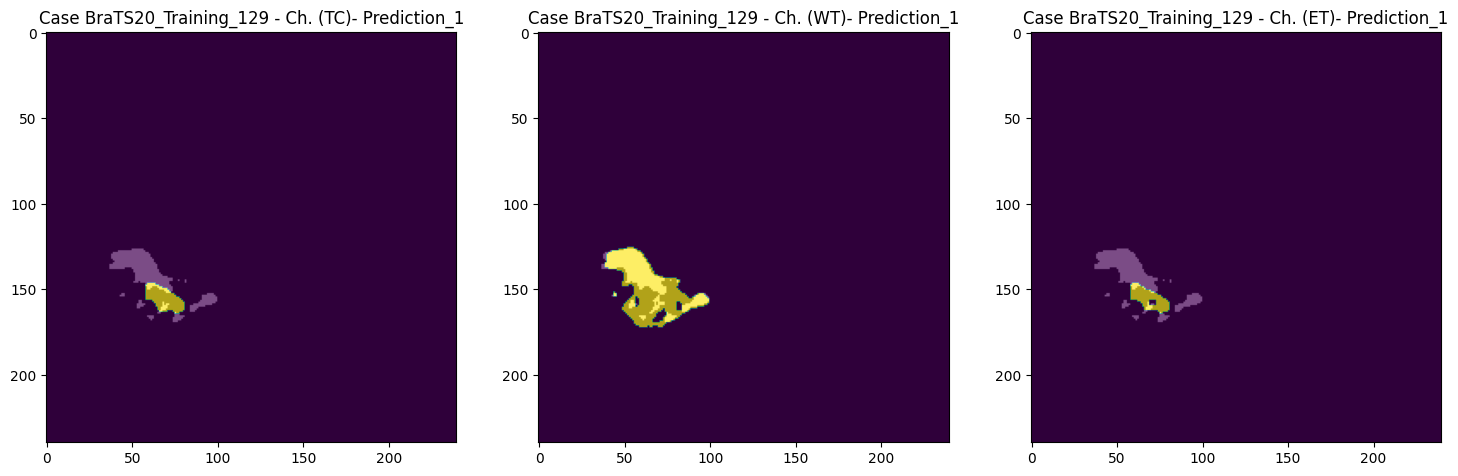

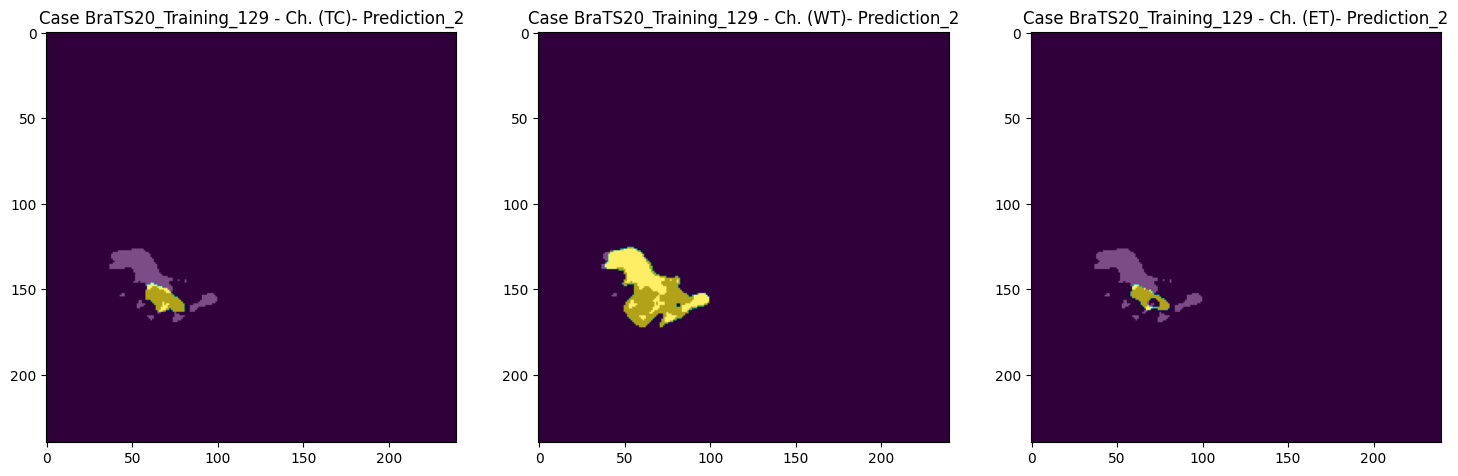

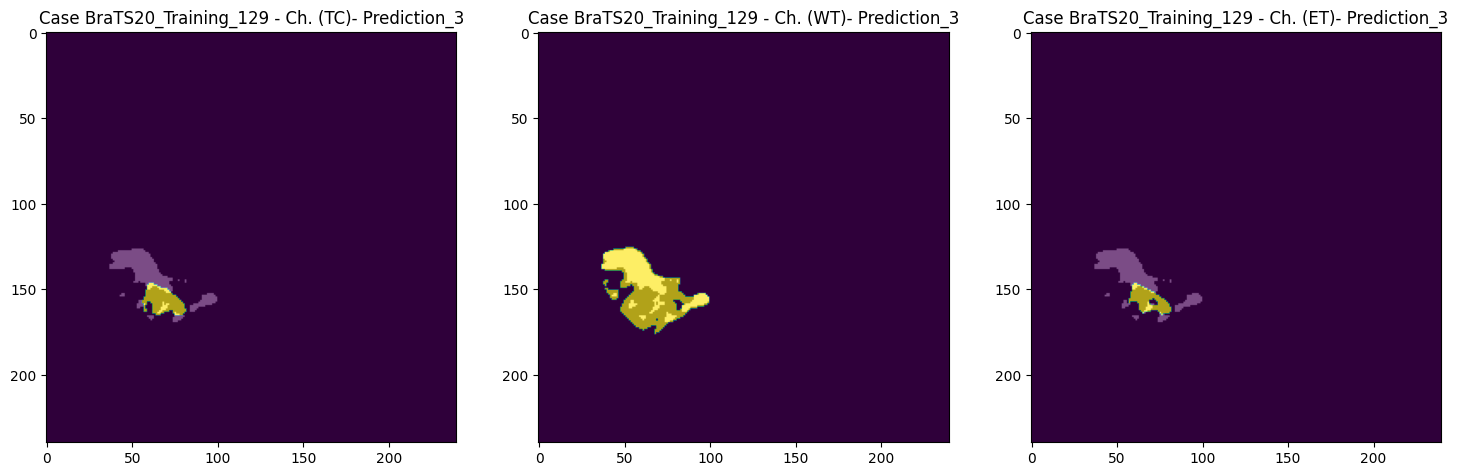

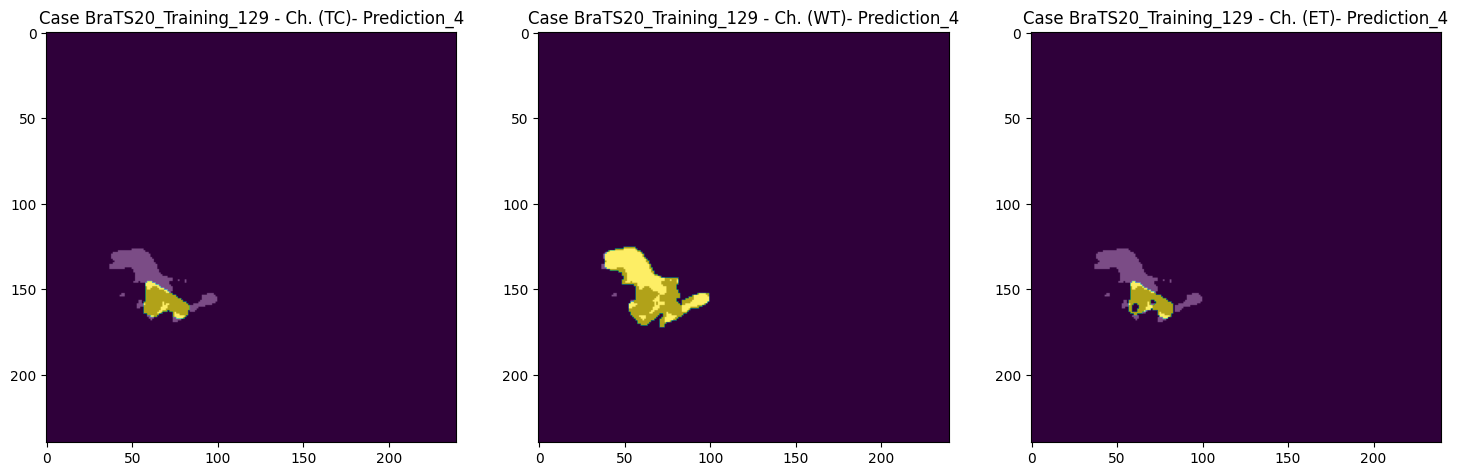

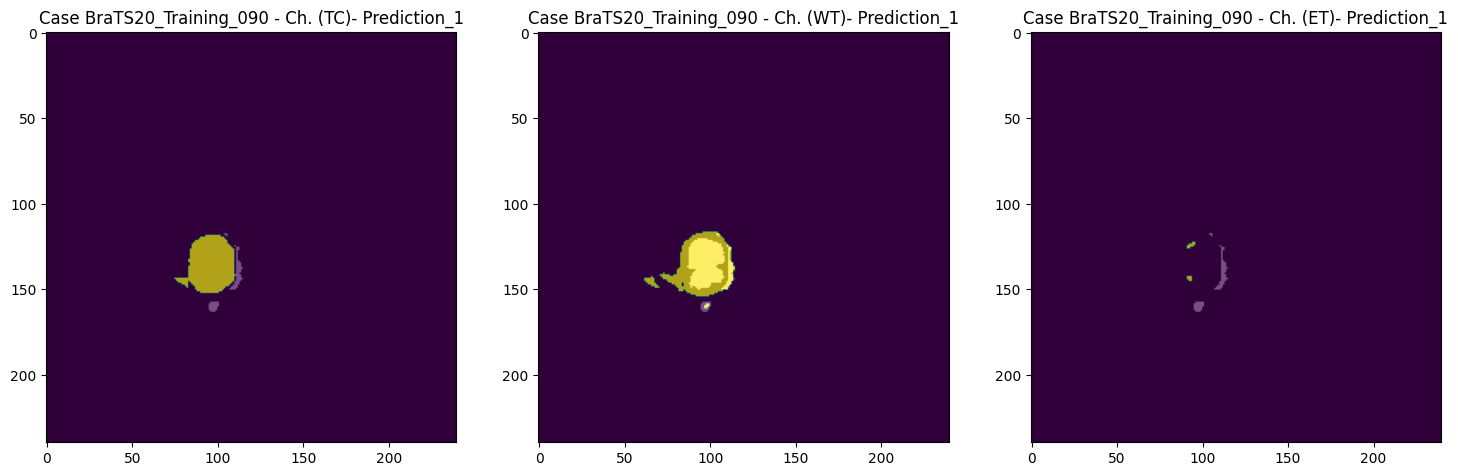

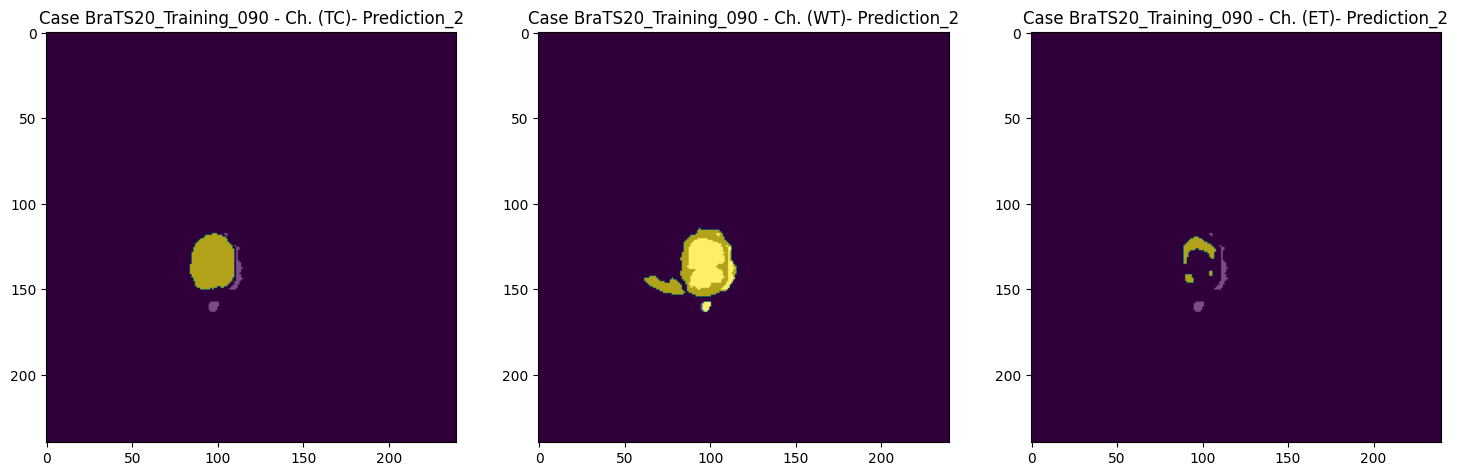

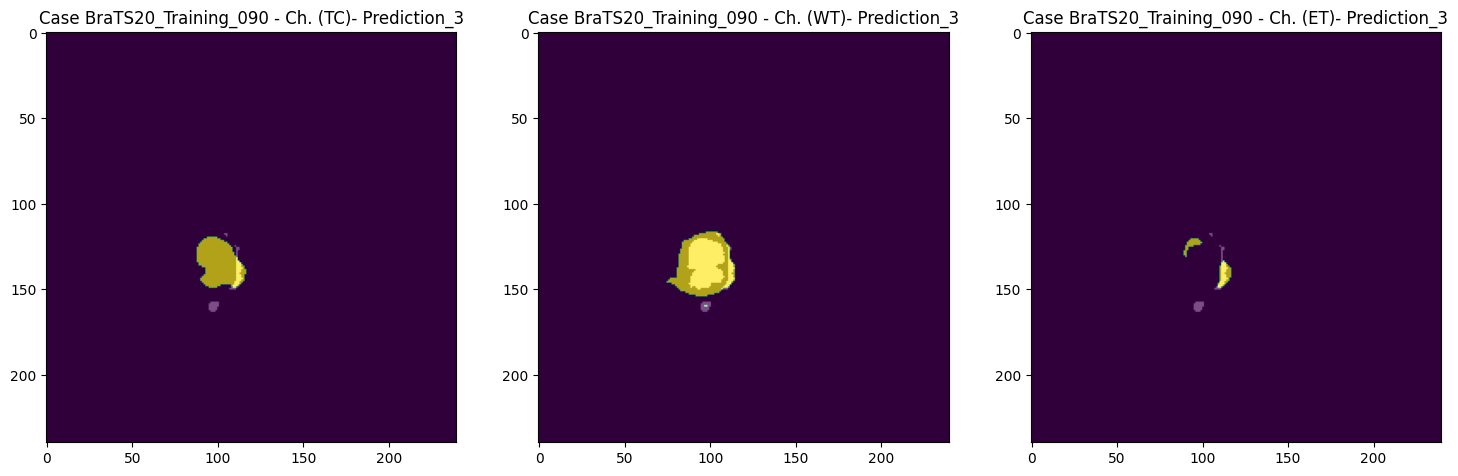

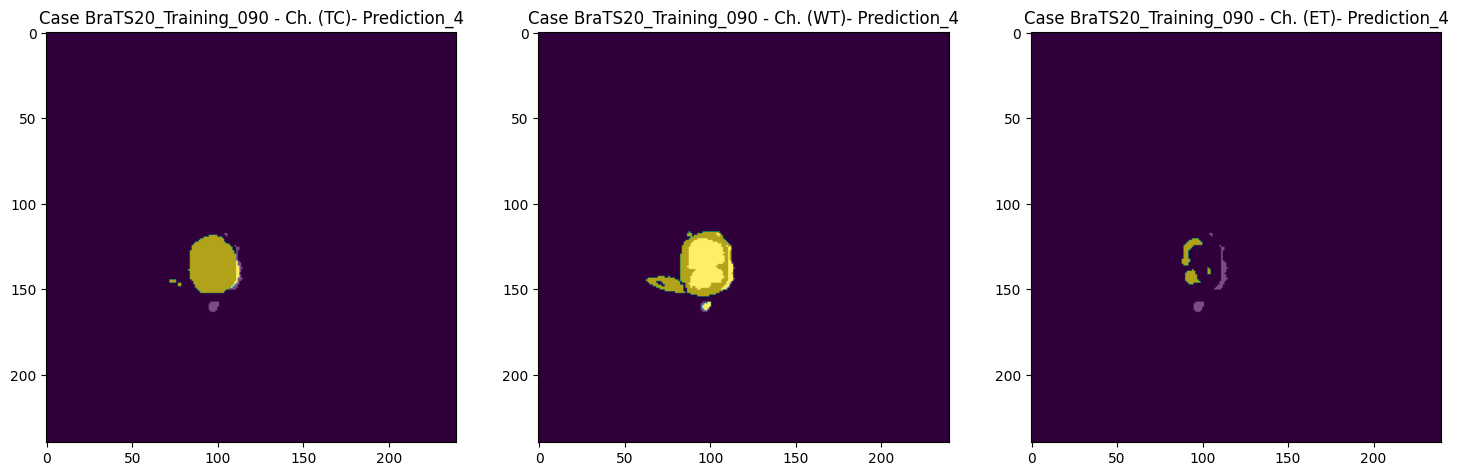

In [ ]:
import matplotlib.pyplot as plt
channel_names = ["TC", "WT", "ET"]
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

with torch.no_grad():
    data = get_data(data_dir)
    num_cases = dropout_predictions.shape[1]

    for case_idx, case_data in enumerate(data[:num_cases]):
        val_input = case_data['image']
        case_name = case_data['folder_name']
        label_tensor = labels[case_idx].cpu().numpy()

        for pass_idx in range(dropout_predictions.shape[0]):
            val_output = dropout_predictions[pass_idx, case_idx]
            val_output = post_trans(val_output)

            plt.figure(f"Case {case_idx + 1} - {case_name} - output_pass_{pass_idx}", (18, 6))
            for i in range(3):
                plt.subplot(1, 3, i + 1)
                plt.title((f"Case {case_name} - Ch. ({channel_names[i]})- Prediction_{pass_idx+1}"))
                plt.imshow(val_output[i, :, :, 70])
                plt.imshow(label_tensor[i, :, :, 70], cmap="gray", alpha=0.3)  # Change the cmap and alpha values as desired
            plt.show()


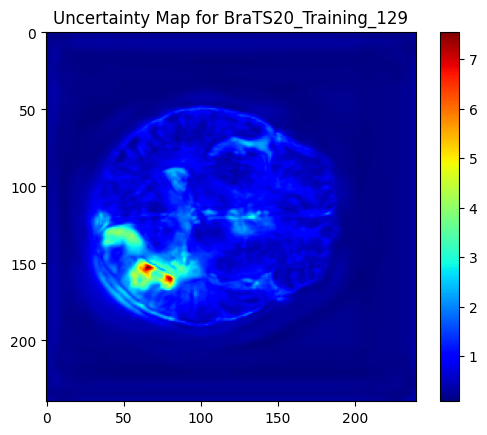

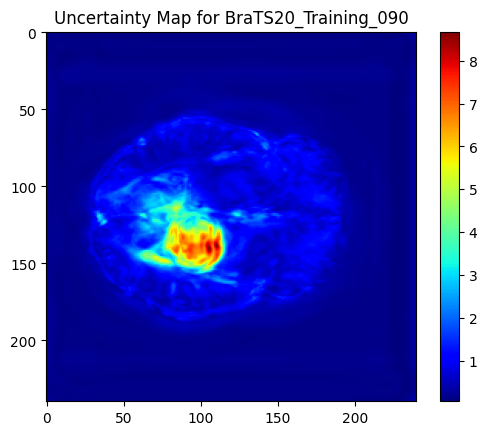

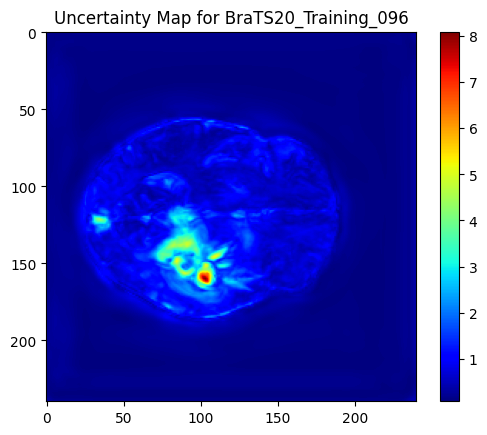

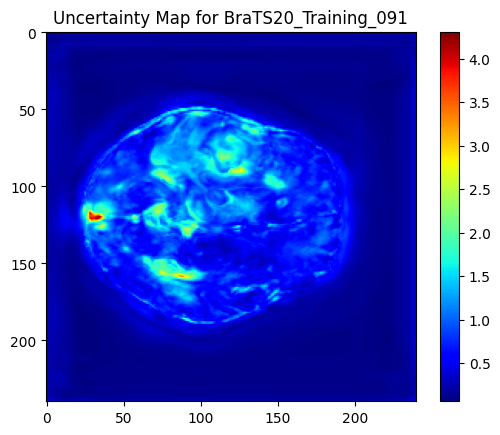

In [ ]:
#The mean represents the expected prediction, while the standard deviation represents the model's uncertainty.

import matplotlib.pyplot as plt
# Assuming you have 2 cases
for i in range(n_samples):
    # Calculate the standard deviation of the predictions across the forward passes
    std_dev = np.std(dropout_predictions, axis=0)

    # Select a single slice to visualize for the current case
    std_dev_slice = std_dev[i, :, :, :, 70]

    # Sum the standard deviations across the channels to create a 2D uncertainty map
    uncertainty_map = np.sum(std_dev_slice, axis=0)

    # Visualize the uncertainty map(STD)
    # val_input_tensor = val_data_dict['image']
    # image = val_input_tensor.cpu().numpy()
    # plt.imshow(image[3, :, :, 70], cmap="gray")
    plt.imshow(uncertainty_map, cmap="jet")
    plt.colorbar()

    # Display the corresponding case folder name for the uncertainty map
    plt.title(f"Uncertainty Map for {data[i]['folder_name']}")
    plt.show()

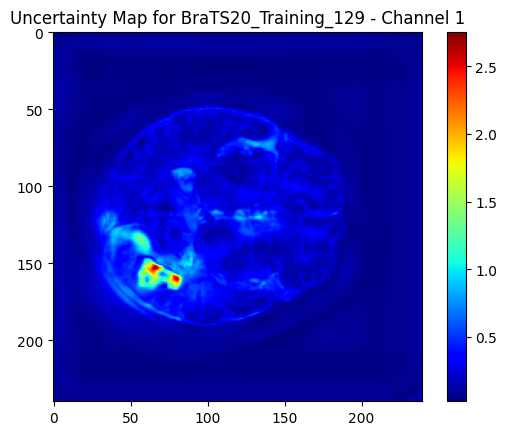

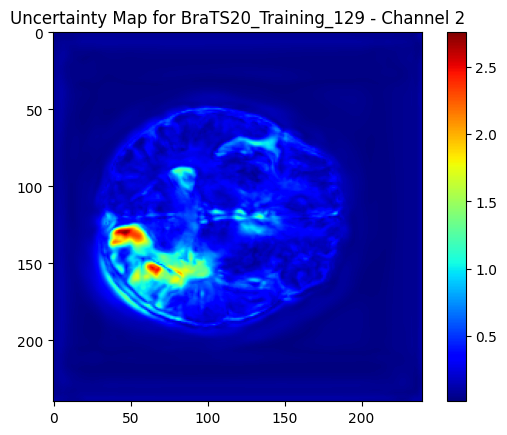

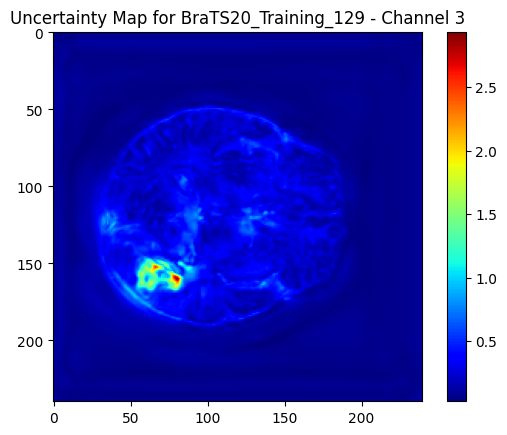

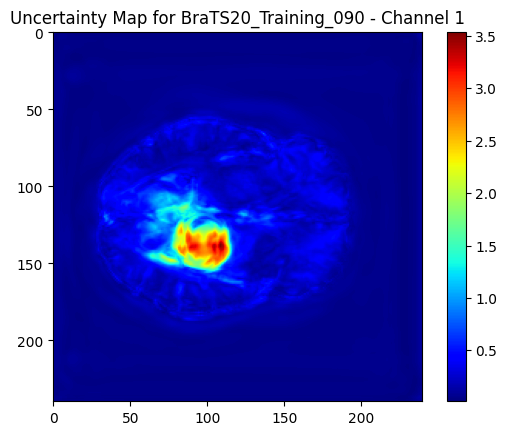

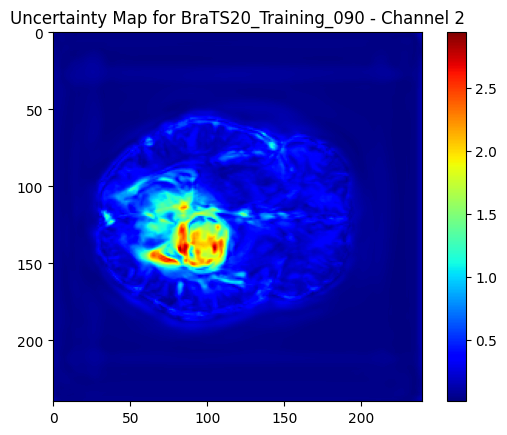

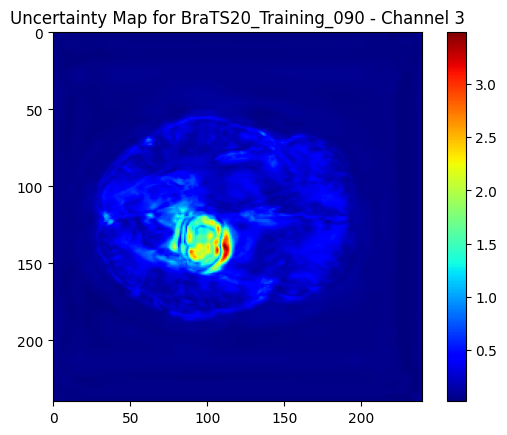

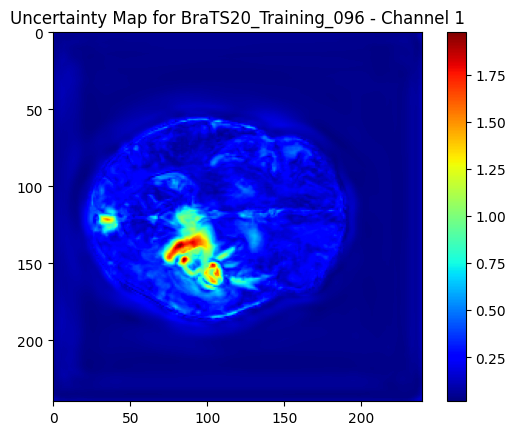

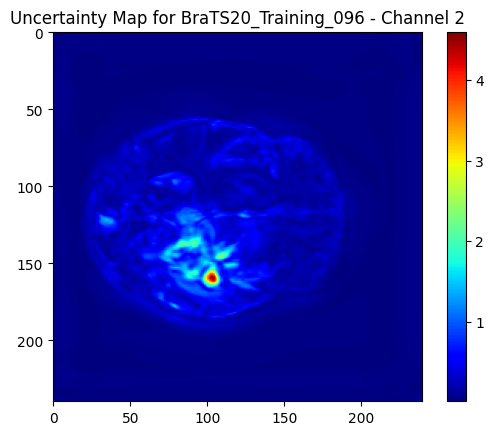

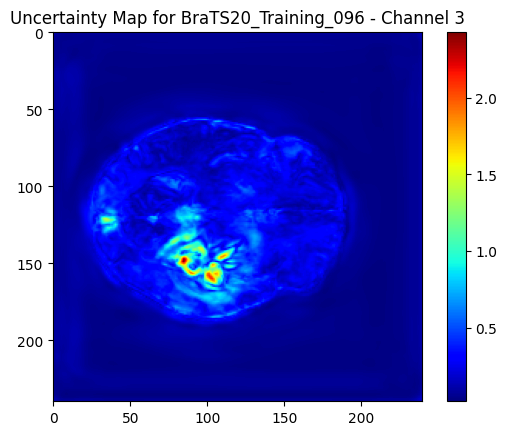

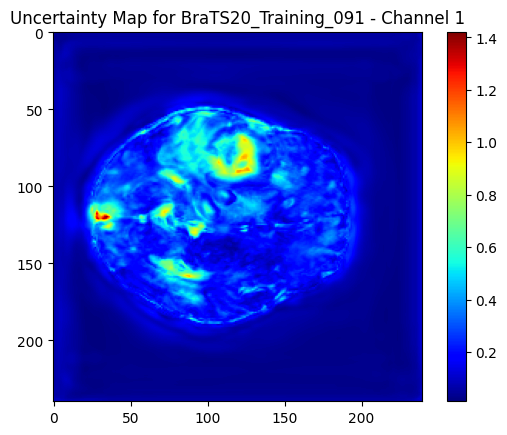

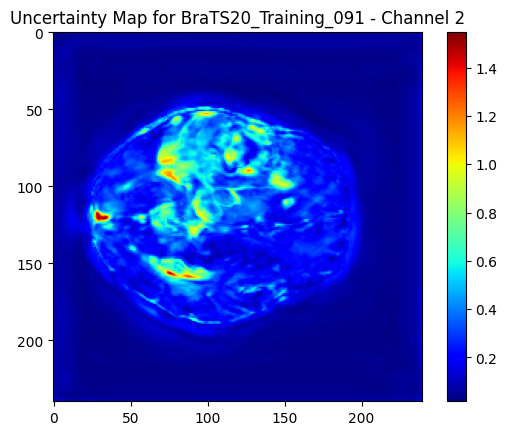

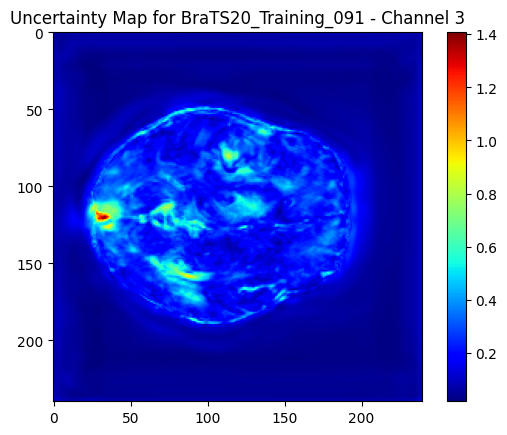

In [ ]:
channel_names = ["TC", "WT", "ET"]

for i in range(n_samples):
    for ch in range(n_classes):
        # Calculate the standard deviation of the predictions across the forward passes
        std_dev = np.std(dropout_predictions[:, i, ch, :, :, :], axis=0)

        # Select a single slice to visualize for the current case
        std_dev_slice = std_dev[:, :, 70]

        # Visualize the uncertainty map(STD)
        plt.imshow(std_dev_slice, cmap="jet")
        plt.colorbar()

        # Display the corresponding case folder name for the uncertainty map
        # Note: replace 'folder_name' with the actual variable holding the folder name if it's different
        plt.title(f"Uncertainty Map for {data[i]['folder_name']} - Channel {ch+1}")
        plt.show()

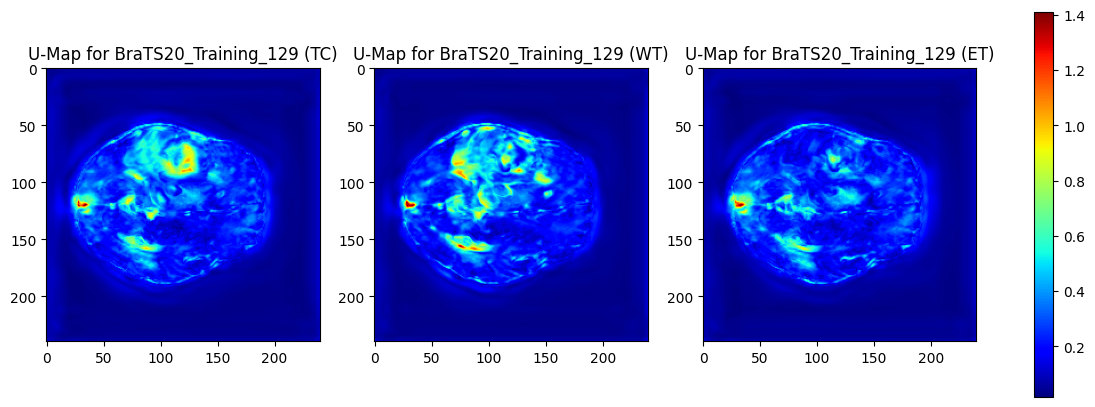

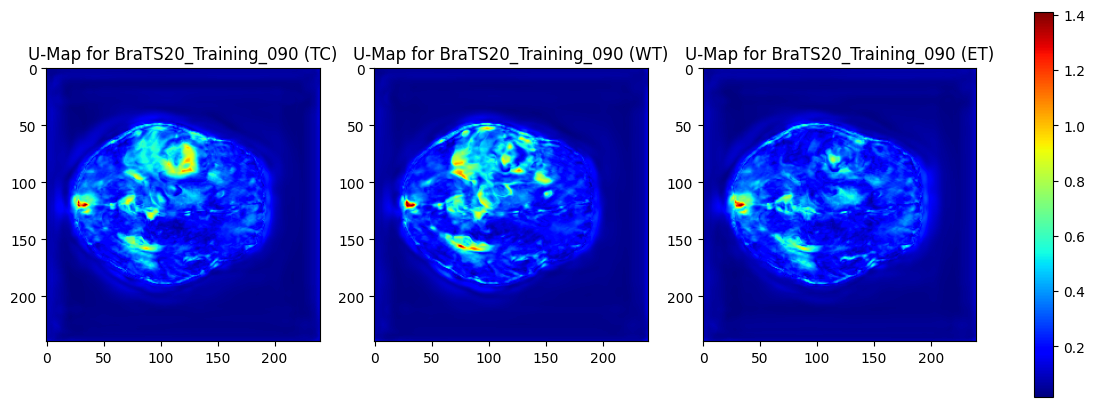

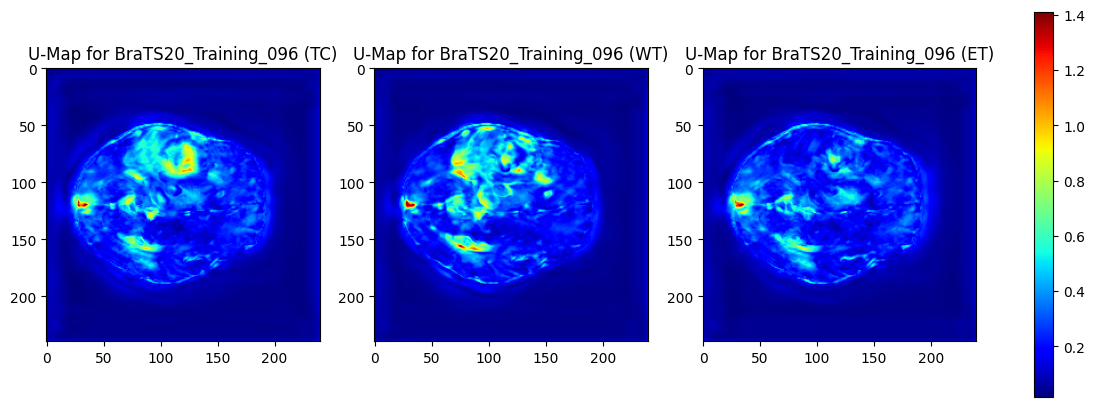

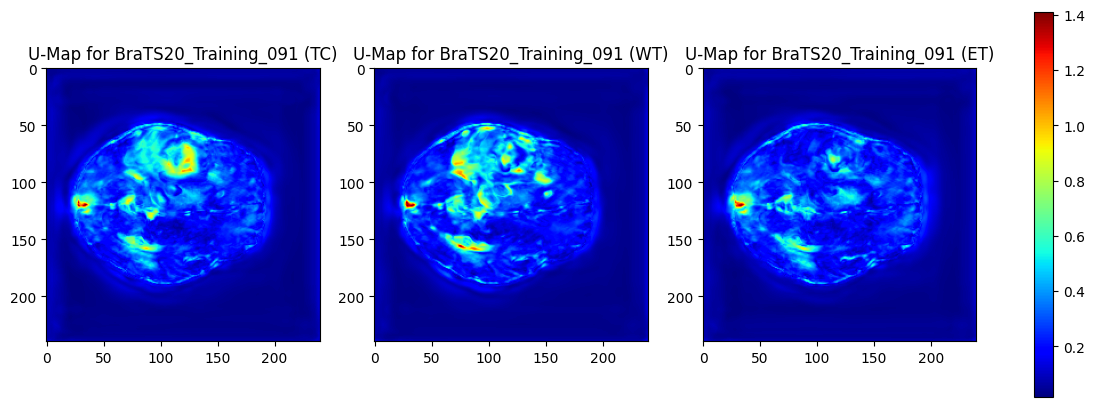

In [ ]:

import matplotlib.pyplot as plt

# std_dev = np.std(dropout_predictions, axis=0)

# std_dev_slice = std_dev[i, :, :, :, 70]
# Assuming you have 2 cases
for j in range(n_samples):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    channel_names = ["TC", "WT", "ET"]

    for i, ax in enumerate(axes):
        uncertainty_map = std_dev_slice[i, :, :]
        im = ax.imshow(uncertainty_map, cmap="jet")
        ax.set_title(f"U-Map for {data[j]['folder_name']} ({channel_names[i]})")

    fig.colorbar(im, ax=axes.ravel().tolist())
    plt.show()


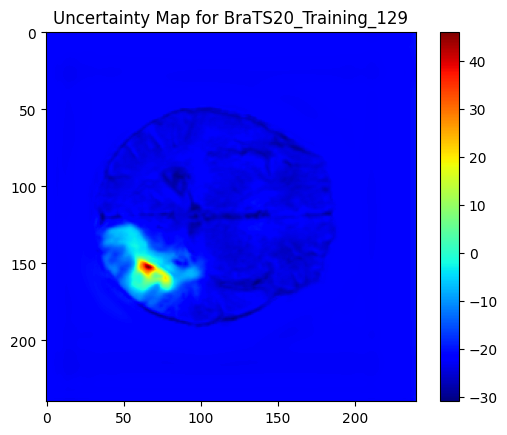

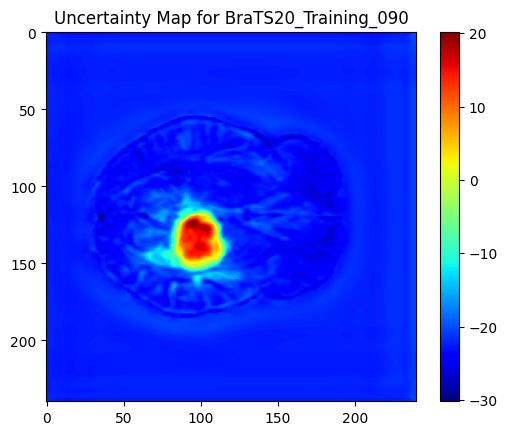

In [ ]:


# # Calculate the Mean of the predictions across the forward passes



for i in range(n_samples):

    mean_output = np.mean(dropout_predictions, axis=0)

    # Select a single slice to visualize for the current case
    mean_output_slice = mean_output[i, :, :, :, 70]

    # Sum the means across the channels to create a 2D uncertainty map
    uncertainty_map_mean = np.sum(mean_output_slice, axis=0)

    # Visualize the uncertainty map(STD)
    val_input_tensor = val_data_dict['image']
    image = val_input_tensor.cpu().numpy()
    plt.imshow(image[3, :, :, 70], cmap="gray")
    plt.imshow(uncertainty_map_mean, cmap="jet")
    plt.colorbar()

    # Display the corresponding case folder name for the uncertainty map
    plt.title(f"Uncertainty Map for {data[i]['folder_name']}")
    plt.show()

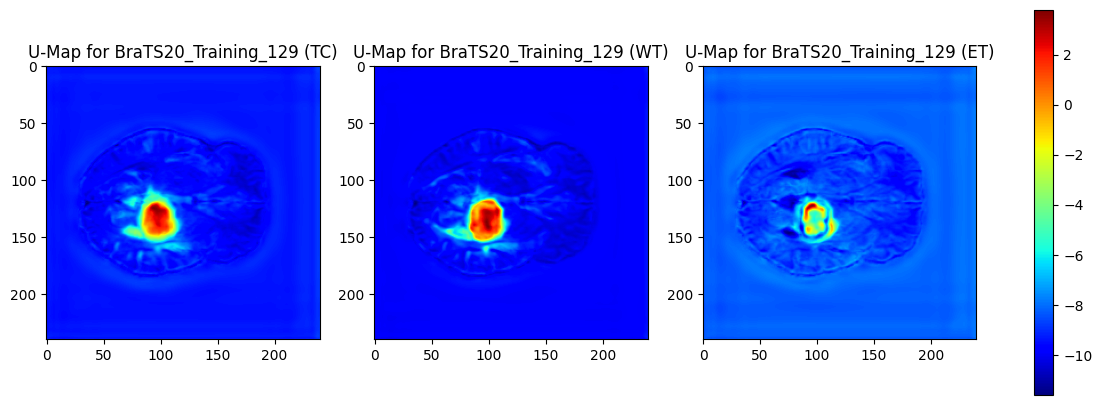

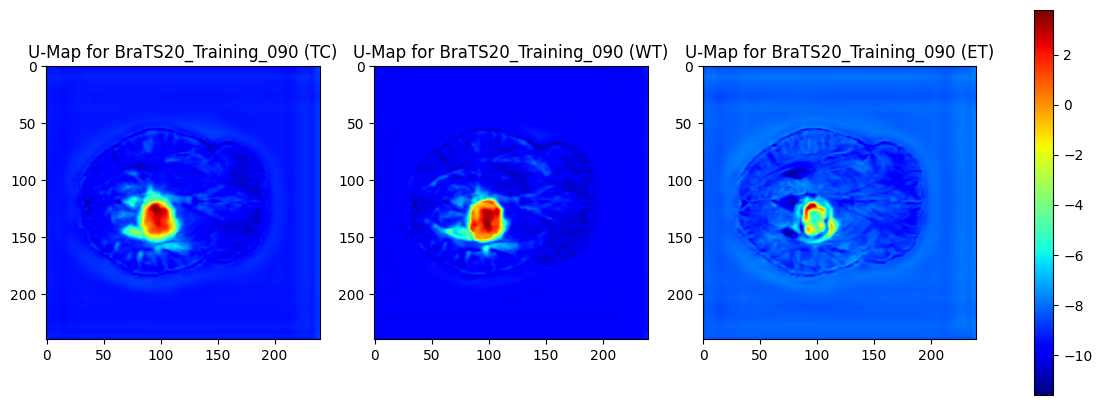

In [ ]:
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
# channel_names = ["TC", "WT", "ET"]

# for i, ax in enumerate(axes):
#     uncertainty_map = mean_output_slice[i, :, :]
#     im = ax.imshow(uncertainty_map, cmap="jet")
#     ax.set_title(f"Uncertainty Map ({channel_names[i]})")

# fig.colorbar(im, ax=axes.ravel().tolist())
# plt.show()
for j in range(n_samples):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    channel_names = ["TC", "WT", "ET"]

    for i, ax in enumerate(axes):
        uncertainty_map = mean_output_slice[i, :, :]
        im = ax.imshow(uncertainty_map, cmap="jet")
        ax.set_title(f"U-Map for {data[j]['folder_name']} ({channel_names[i]})")

    fig.colorbar(im, ax=axes.ravel().tolist())
    plt.show()


In [ ]:
import matplotlib.pyplot as plt

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
label_transform = ConvertToMultiChannelBasedOnBratsClassesd(keys="label")

with torch.no_grad():

    data = get_data(data_dir)
    num_cases = dropout_predictions.shape[1]

    for case_idx, case_data in enumerate(data[:num_cases]):
        case_name = case_data['folder_name']
        label_file = case_data['label']
        label_data = nib.load(label_file).get_fdata()
        label_dict = label_transform({"label": torch.tensor(label_data)})
        label_tensor = label_dict["label"]

        # Calculate the mean of the predictions across the forward passes
        mean_output = np.mean(dropout_predictions[:, case_idx], axis=0)
        mean_output = post_trans(mean_output)

        plt.figure(f"output_case_{case_idx + 1}", (18, 6))
        for i in range(3):
            plt.subplot(1, 3, i + 1)
            plt.title(f"Case {case_name} - Output channel {i}")
            plt.imshow(mean_output[i, :, :, 70].detach().cpu())
            plt.imshow(np.rot90(label_tensor[i, :, :, 70].detach().cpu(), k=2), cmap="jet", alpha=0.3)
        plt.show()


NameError: ignored

In [ ]:
##   different threshold    ##

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.9)])

with torch.no_grad():
    val_input = get_data('Input')[0]['image']

    # Calculate the mean of the predictions across the forward passes
    mean_output = np.mean(dropout_predictions, axis=0)
    mean_output = post_trans(mean_output)

    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(image[0][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()

    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        print(torch.max(mean_output[0, i, :, :, 70].detach().cpu()))
        plt.imshow(mean_output[0, i, :, :, 70].detach().cpu())
    plt.show()


In [ ]:
import pandas as pd


import torch
import torch.nn as nn
import pandas as pd

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, pred, label, smooth=1):
        # Comment out if your model contains a sigmoid or equivalent activation layer
        pred = torch.sigmoid(pred)

        # Sum the channels for the prediction and the label
        pred_sum = torch.sum(pred, dim=1)
        label_sum = label.sum(dim=1)

        # Expand label_sum to match pred_sum shape
        label_sum = label_sum.unsqueeze(0).expand(pred_sum.shape[0], -1, -1, -1)

        intersection = (pred_sum * label_sum).sum()
        dice = (2. * intersection + smooth) / (pred_sum.sum() + label_sum.sum() + smooth)

        loss = 1 - dice

        return loss, dice



# Instantiate the DiceLoss class
dice_loss = DiceLoss()



    # for i in range(pred.shape[0]):
    #     single_pred = pred[i]  # Extract a single prediction
    #     loss, dice_coeff = dice_loss(single_pred, case_label)
    #     print(f"Case {case_folder_name}, Prediction {i + 1}: Dice Loss = {loss.item()}, Dice Coefficient = {dice_coeff.item()}")

# Modify the loop for saving the results
results = []

# Iterate through the cases
for case_index, data_dict in enumerate(data):
    case_folder_name = data_dict['folder_name']
    case_labels = data_dict['label'].to(device)

    # Iterate through the predictions
    for i in range(pred.shape[0]):
        single_pred = pred[i]  # Extract a single prediction
        loss, dice_coeff = dice_loss(single_pred, case_labels)

        # Append the result as a dictionary to the list
        results.append({
            'Case': case_folder_name,
            'Prediction': i + 1,
            'Sum Dice Loss': loss.item(),
            'Sum Dice Coefficient': dice_coeff.item()
        })

# Create a DataFrame from the results list
df_sum_Dice = pd.DataFrame(results)

# Display the DataFrame
print(df_sum_Dice)

# Save the DataFrame to a CSV file
#df_sum_Dice.to_csv("dice_results.csv", index=False)


RuntimeError: ignored